In [2]:
import json
import csv
import pandas as pd
import numpy as np
import scipy as sci
import keras
from keras.models import Sequential
from keras import regularizers
from keras.layers.core import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
import requests
import tensorflow as tf
from scipy import sparse
from sklearn.model_selection import train_test_split
import sklearn.feature_extraction.text as sk_text
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Useful Functions 

In [14]:
#Function to normalize columns
def normalize_numeric_minmax(df, name):
    if(df[name].max() > 0):
        df[name] = ((df[name] - df[name].min()) / (df[name].max() - df[name].min())).astype(np.float32)
    else:
        df[name] = df[name].astype(np.float32)

In [15]:
# one-hot cooding of categorical columns

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name]).astype(np.float32)
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [16]:
# create a function called encodeLabelBinarizer

encodeLabelBinary = lambda x: 0 if x == 'normal.' else 1

In [17]:
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
import collections
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [18]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_



In [19]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [20]:
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    

# Training and prediction with classic regression and classification model

## Data Processing 

In [9]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_df= pd.read_csv('network_intrusion_data.csv')

In [10]:
#Drop any row with missing values
network_df = network_df.dropna()

In [11]:
#Add column headers to the data in the dataframe
network_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [12]:
#Select colums for feature
features_df = network_df[['duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
                          
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
                          
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']]

In [13]:
#Label column
label_df = network_df[['outcome']]

In [14]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(features_df,"duration") 
normalize_numeric_minmax(features_df,"src_bytes") 
normalize_numeric_minmax(features_df,"dst_bytes") 
normalize_numeric_minmax(features_df,"wrong_fragment") 
normalize_numeric_minmax(features_df,"urgent") 

normalize_numeric_minmax(features_df,"hot") 
normalize_numeric_minmax(features_df,"num_failed_logins") 
normalize_numeric_minmax(features_df,"num_compromised") 
normalize_numeric_minmax(features_df,"num_root") 
normalize_numeric_minmax(features_df,"num_file_creations") 
normalize_numeric_minmax(features_df,"num_shells") 
normalize_numeric_minmax(features_df,"num_access_files") 
normalize_numeric_minmax(features_df,"num_outbound_cmds") 

normalize_numeric_minmax(features_df,"count") 
normalize_numeric_minmax(features_df,"srv_count") 
normalize_numeric_minmax(features_df,"serror_rate") 
normalize_numeric_minmax(features_df,"rerror_rate") 
normalize_numeric_minmax(features_df,"srv_rerror_rate")  
normalize_numeric_minmax(features_df,"same_srv_rate") 
normalize_numeric_minmax(features_df,"diff_srv_rate") 
normalize_numeric_minmax(features_df,"srv_diff_host_rate") 
normalize_numeric_minmax(features_df,"dst_host_count") 
normalize_numeric_minmax(features_df,"dst_host_srv_count") 
normalize_numeric_minmax(features_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(features_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(features_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(features_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(features_df,"dst_host_serror_rate") 
normalize_numeric_minmax(features_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(features_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(features_df,"dst_host_srv_rerror_rate") 

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
#One hot coding discrete values (9)
encode_text_dummy(features_df,"protocol_type") 
encode_text_dummy(features_df,"service") 
encode_text_dummy(features_df,"flag") 
encode_text_dummy(features_df,"land") 

encode_text_dummy(features_df,"logged_in") 
encode_text_dummy(features_df,"root_shell") 
encode_text_dummy(features_df,"su_attempted") 
encode_text_dummy(features_df,"is_host_login") 
encode_text_dummy(features_df,"is_guest_login") 

In [16]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
features_df = features_df[0:10000]
label_df = label_df[0:10000]

In [17]:
#Binary encode the label column
label_df['outcome'] = label_df['outcome'].apply(encodeLabelBinary)

In [18]:
#Split for training and testing
x_train, x_test, y_train, y_test = train_test_split(features_df, label_df['outcome'] , test_size=0.2, random_state=42)

## Logistic Regression    - score_logistic

In [19]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_train, y_train)

y_pred_logistic = Log_reg_model.predict(x_test)

In [142]:
# Metrics

score_acc_log = metrics.accuracy_score(y_test, y_pred_logistic)
print("Accuracy score: {}".format(score_acc_log))

score_precision_log = metrics.precision_score(y_test, y_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_precision_log))

score_recall_log = metrics.recall_score(y_test, y_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_recall_log))

score_f1_log = metrics.f1_score(y_test, y_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_f1_log))

Accuracy score: 0.998
Precision score: 0.9980051085568328
Recall score: 0.998
F1 score: 0.9979966916164151


In [127]:
cm_log = confusion_matrix(y_test, y_pred_logistic)
print(cm_cnn)

[[1562    0]
 [   0  438]]


In [133]:
outcome = encode_text_index(label_df,'outcome')

In [134]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


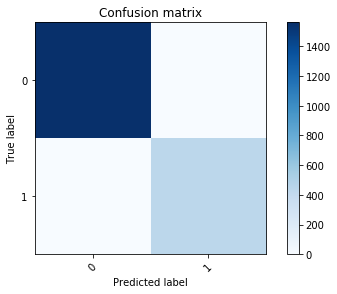

In [135]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_log, outcome)
plt.show()

In [136]:
print(classification_report(y_test, y_pred_logistic))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      0.99      1.00       438

avg / total       1.00      1.00      1.00      2000



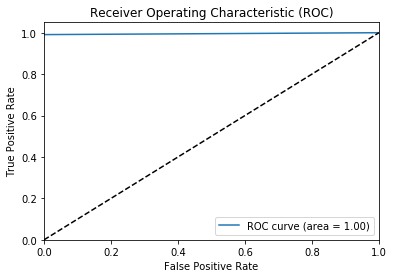

In [150]:
pred_log = Log_reg_model.predict(x_test)
pred_log = pred_log[:]
plot_roc(pred_log,y_test)

## Clssification Models 

### KNN   - score_knn_acc

In [21]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_train, y_train) 

y_pred_knn = knn.predict(x_test)

In [22]:
# Metrics
from sklearn import metrics

score_knn_acc = metrics.accuracy_score(y_test, y_pred_knn)
print("Accuracy score: {}".format(score_knn_acc))

score_knn_precision = metrics.precision_score(y_test, y_pred_knn, average= "weighted")
print("Precision score: {}".format(score_knn_precision))

score_knn_recall = metrics.recall_score(y_test, y_pred_knn, average= "weighted")
print("Recall score: {}".format(score_knn_recall))

score_knn_f1 = metrics.f1_score(y_test, y_pred_knn, average= "weighted")
print("F1 score: {}".format(score_knn_f1))

Accuracy score: 0.998
Precision score: 0.9980051085568328
Recall score: 0.998
F1 score: 0.9979966916164151


In [151]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

[[1562    0]
 [   4  434]]


In [155]:
outcome = encode_text_index(label_df,'outcome')

In [156]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


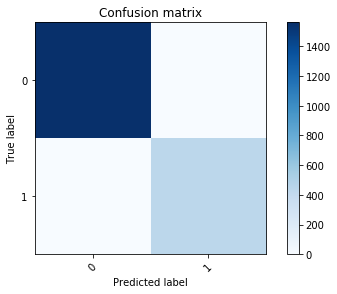

In [157]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_knn, outcome)
plt.show()

In [158]:
print(classification_report(y_test, y_pred_knn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      0.99      1.00       438

avg / total       1.00      1.00      1.00      2000



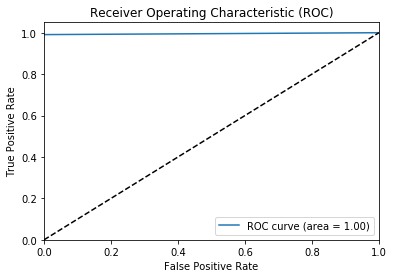

In [160]:
pred_knn = knn.predict(x_test)
pred_knn = pred_knn[:]
plot_roc(pred_knn,y_test)

### SVM   - score_svm_acc

In [23]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")

svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)

In [24]:
# Metrics

score_svm_acc = metrics.accuracy_score(y_test, y_pred_svm)
print("Accuracy score: {}".format(score_svm_acc))

score_svm_precision = metrics.precision_score(y_test, y_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision))

score_svm_recall = metrics.recall_score(y_test, y_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall))

score_svm_f1 = metrics.f1_score(y_test, y_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1))

Accuracy score: 0.9985
Precision score: 0.998502875399361
Recall score: 0.9985
F1 score: 0.9984981422199071


In [161]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

[[1562    0]
 [   3  435]]


In [162]:
outcome = encode_text_index(label_df,'outcome')

In [163]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


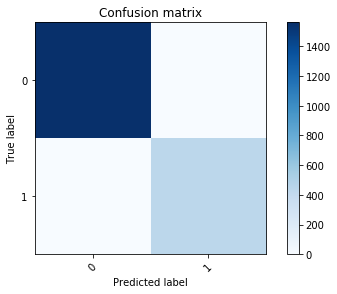

In [164]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_svm, outcome)
plt.show()

In [165]:
print(classification_report(y_test, y_pred_svm))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      0.99      1.00       438

avg / total       1.00      1.00      1.00      2000



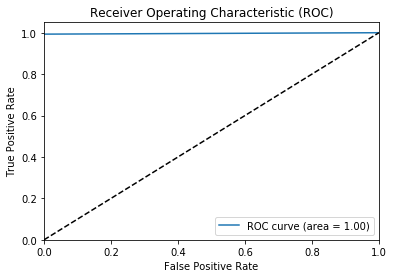

In [166]:
pred_svm = svm_model.predict(x_test)
pred_svm = pred_svm[:]
plot_roc(pred_svm,y_test)

### Gaussian Naive Bayes     - score_gnb_acc

In [173]:
#GNB
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

gnb_model.fit(x_train, y_train)

y_pred_gnb = gnb_model.predict(x_test)

In [174]:
# Metrics

score_gnb_acc = metrics.accuracy_score(y_test, y_pred_gnb)
print("Accuracy score: {}".format(score_gnb_acc))

score_gnb_precision = metrics.precision_score(y_test, y_pred_gnb, average= "weighted")
print("Precision score: {}".format(score_gnb_precision))

score_gnb_recall = metrics.recall_score(y_test, y_pred_gnb, average= "weighted")
print("Recall score: {}".format(score_gnb_recall))

score_gnb_f1 = metrics.f1_score(y_test, y_pred_gnb, average= "weighted")
print("F1 score: {}".format(score_gnb_f1))

Accuracy score: 0.996
Precision score: 0.9960094405594406
Recall score: 0.996
F1 score: 0.9960032745786752


In [175]:
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print(cm_gnb)

[[1557    5]
 [   3  435]]


In [176]:
outcome = encode_text_index(label_df,'outcome')

In [177]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


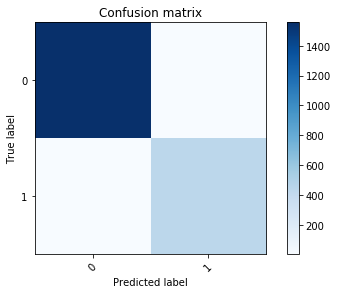

In [178]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_gnb, outcome)
plt.show()

In [179]:
print(classification_report(y_test, y_pred_gnb))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       0.99      0.99      0.99       438

avg / total       1.00      1.00      1.00      2000



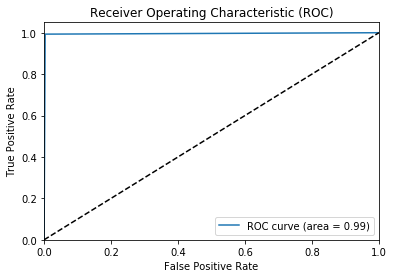

In [180]:
pred_gnb = gnb_model.predict(x_test)
pred_gnb = pred_gnb[:]
plot_roc(pred_gnb,y_test)

# Fully connected Neural Network and Convolutional Neural Network

## Data Processing 

In [40]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_nn_df= pd.read_csv('network_intrusion_data.csv')

In [41]:
#Drop any row with missing values
network_nn_df = network_nn_df.dropna()

In [42]:
#Add column headers to the data in the dataframe
network_nn_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [43]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(network_nn_df,"duration") 
normalize_numeric_minmax(network_nn_df,"src_bytes") 
normalize_numeric_minmax(network_nn_df,"dst_bytes") 
normalize_numeric_minmax(network_nn_df,"wrong_fragment") 
normalize_numeric_minmax(network_nn_df,"urgent") 

normalize_numeric_minmax(network_nn_df,"hot") 
normalize_numeric_minmax(network_nn_df,"num_failed_logins") 
normalize_numeric_minmax(network_nn_df,"num_compromised") 
normalize_numeric_minmax(network_nn_df,"num_root") 
normalize_numeric_minmax(network_nn_df,"num_file_creations") 
normalize_numeric_minmax(network_nn_df,"num_shells") 
normalize_numeric_minmax(network_nn_df,"num_access_files") 
normalize_numeric_minmax(network_nn_df,"num_outbound_cmds") 

normalize_numeric_minmax(network_nn_df,"count") 
normalize_numeric_minmax(network_nn_df,"srv_count") 
normalize_numeric_minmax(network_nn_df,"serror_rate") 
normalize_numeric_minmax(network_nn_df,"rerror_rate") 
normalize_numeric_minmax(network_nn_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_nn_df,"same_srv_rate") 
normalize_numeric_minmax(network_nn_df,"diff_srv_rate") 
normalize_numeric_minmax(network_nn_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_count") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_nn_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_nn_df,"dst_host_srv_rerror_rate") 

In [44]:
#One hot coding discrete values (9)
encode_text_dummy(network_nn_df,"protocol_type") 
encode_text_dummy(network_nn_df,"service") 
encode_text_dummy(network_nn_df,"flag") 
encode_text_dummy(network_nn_df,"land") 
encode_text_dummy(network_nn_df,"logged_in") 
encode_text_dummy(network_nn_df,"root_shell") 
encode_text_dummy(network_nn_df,"su_attempted") 
encode_text_dummy(network_nn_df,"is_host_login") 
encode_text_dummy(network_nn_df,"is_guest_login") 

In [45]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
network_nn_df = network_nn_df[0:10000]

In [46]:
#Binary encode the label column
network_nn_df['outcome'] = network_nn_df['outcome'].apply(encodeLabelBinary)

In [47]:
# to xy to convert pandas to tensor flow
x,y=to_xy(network_nn_df,"outcome")

## Fully Connected Neural Network  

In [66]:
#Split for train and test
x_nn_train, x_nn_test, y_nn_train, y_nn_test = train_test_split(x,y, test_size=0.2, random_state=42)

#### ReLU, adam, 4 layers, early stopping and Model checkpoint  - score_4l

In [73]:
# set up checkpointer
checkpointer_relu = ModelCheckpoint(filepath="./best_weights_relu_4l_nn.hdf5", verbose=1, save_best_only=True)

In [75]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()
    model_reg_relu.add(Dense(10, input_dim=x_nn_train.shape[1], activation='relu'))
    model_reg_relu.add(Dense(50, activation='relu'))
    model_reg_relu.add(Dense(10, activation='relu'))
    model_reg_relu.add(Dense(1))
    model_reg_relu.add(Dense(y.shape[1],activation='softmax'))
    model_reg_relu.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_relu ],verbose=2,epochs=1000)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l_nn.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
 - 4s - loss: 0.1078 - val_loss: 0.0135

Epoch 00001: val_loss did not improve from 0.00023
Epoch 2/1000
 - 1s - loss: 0.0039 - val_loss: 0.0124

Epoch 00002: val_loss did not improve from 0.00023
Epoch 3/1000
 - 1s - loss: 0.0026 - val_loss: 0.0106

Epoch 00003: val_loss did not improve from 0.00023
Epoch 4/1000
 - 1s - loss: 0.0020 - val_loss: 0.0076

Epoch 00004: val_loss did not improve from 0.00023
Epoch 5/1000
 - 1s - loss: 0.0014 - val_loss: 0.0057

Epoch 00005: val_loss did not improve from 0.00023
Epoch 6/1000
 - 1s - loss: 0.0011 - val_loss: 0.0037

Epoch 00006: val_loss did not improve from 0.00023
Epoch 7/1000
 - 1s - loss: 8.4701e-04 - val_loss: 0.0022

Epoch 00007: val_loss did not improve from 0.00023
Epoch 8/1000
 - 1s - loss: 8.4744e-04 - val_loss: 0.0017

Epoch 00008: val_loss did not improve from 0.00023
Epoch 9/1000
 - 1s - loss: 5.9857e-04 - val_loss: 5.5381e-04

Epoch 00009: val_loss did not improve fr

 - 2s - loss: 2.1845e-05 - val_loss: 7.5847e-05

Epoch 00020: val_loss improved from 0.00009 to 0.00008, saving model to ./best_weights_relu_4l_nn.hdf5
Epoch 21/1000
 - 1s - loss: 1.8743e-05 - val_loss: 9.4280e-05

Epoch 00021: val_loss did not improve from 0.00008
Epoch 00021: early stopping
4
Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
 - 6s - loss: 0.1121 - val_loss: 0.0140

Epoch 00001: val_loss did not improve from 0.00008
Epoch 2/1000
 - 1s - loss: 0.0034 - val_loss: 0.0105

Epoch 00002: val_loss did not improve from 0.00008
Epoch 3/1000
 - 1s - loss: 0.0024 - val_loss: 0.0083

Epoch 00003: val_loss did not improve from 0.00008
Epoch 4/1000
 - 1s - loss: 0.0015 - val_loss: 0.0055

Epoch 00004: val_loss did not improve from 0.00008
Epoch 5/1000
 - 1s - loss: 0.0012 - val_loss: 0.0033

Epoch 00005: val_loss did not improve from 0.00008
Epoch 6/1000
 - 1s - loss: 8.3742e-04 - val_loss: 0.0016

Epoch 00006: val_loss did not improve from 0.00008
Epoch 7/1000
 - 1s - l

 - 1s - loss: 8.7227e-06 - val_loss: 1.2746e-04

Epoch 00022: val_loss did not improve from 0.00008
Epoch 00022: early stopping
8
Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
 - 5s - loss: 0.2128 - val_loss: 0.0158

Epoch 00001: val_loss did not improve from 0.00008
Epoch 2/1000
 - 1s - loss: 0.0040 - val_loss: 0.0132

Epoch 00002: val_loss did not improve from 0.00008
Epoch 3/1000
 - 1s - loss: 0.0025 - val_loss: 0.0124

Epoch 00003: val_loss did not improve from 0.00008
Epoch 4/1000
 - 2s - loss: 0.0020 - val_loss: 0.0079

Epoch 00004: val_loss did not improve from 0.00008
Epoch 5/1000
 - 1s - loss: 0.0017 - val_loss: 0.0063

Epoch 00005: val_loss did not improve from 0.00008
Epoch 6/1000
 - 1s - loss: 0.0010 - val_loss: 0.0042

Epoch 00006: val_loss did not improve from 0.00008
Epoch 7/1000
 - 2s - loss: 6.0776e-04 - val_loss: 0.0019

Epoch 00007: val_loss did not improve from 0.00008
Epoch 8/1000
 - 2s - loss: 3.3655e-04 - val_loss: 6.2568e-04

Epoch 00008: val_loss

In [77]:
# Measure accuracy
pred_nn = model_reg_relu.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [78]:
# Metrics

score_tf_acc_relu = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_relu))

score_tf_precision_relu = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_relu))

score_tf_recall_relu = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_relu))

score_tf_f1_relu = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_relu))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [181]:
cm_relu = confusion_matrix(y_eval, pred_nn)
print(cm_relu)

[[1562    0]
 [   0  438]]


In [182]:
outcome = encode_text_index(network_nn_df,'outcome')

In [183]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


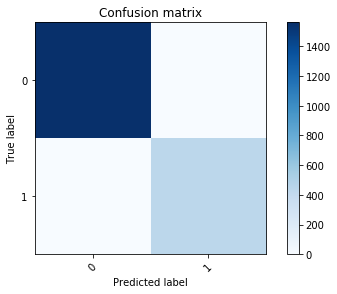

In [184]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_relu, outcome)
plt.show()

In [185]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      1.00      1.00       438

avg / total       1.00      1.00      1.00      2000



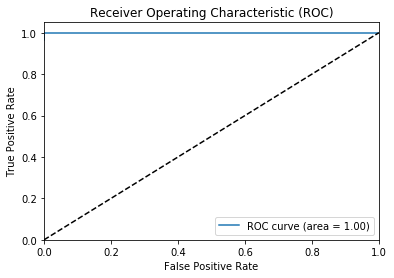

In [191]:
pred_relu = model_reg_relu.predict(x_nn_test)
pred_relu = pred_relu[:,1]
plot_roc(pred_relu,y_eval)

#### Sigmoid, adam, 4 layers  -score_reg_sig_stopping 

In [84]:
# set up checkpointer
checkpointer_sigmoid = ModelCheckpoint(filepath="./best_weights_sigmoid_nn.hdf5", verbose=1, save_best_only=True)

In [89]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_nn_train.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(y.shape[1],activation='softmax')) # Output
    model_reg_sig.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_sigmoid],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid_nn.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 5s - loss: 0.2338 - val_loss: 0.0454

Epoch 00001: val_loss improved from inf to 0.04541, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 2/100
 - 1s - loss: 0.0233 - val_loss: 0.0230

Epoch 00002: val_loss improved from 0.04541 to 0.02299, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 3/100
 - 1s - loss: 0.0110 - val_loss: 0.0181

Epoch 00003: val_loss improved from 0.02299 to 0.01812, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 4/100
 - 1s - loss: 0.0072 - val_loss: 0.0164

Epoch 00004: val_loss improved from 0.01812 to 0.01640, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 5/100
 - 1s - loss: 0.0054 - val_loss: 0.0157

Epoch 00005: val_loss improved from 0.01640 to 0.01570, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 6/100
 - 1s - loss: 0.0044 - val_loss: 0.0154

Epoch 00006: val_loss improved from 0.01570 to 0.01543, saving model to ./best_weights_sigmoid_nn.hdf5
Epoch 7/100
 - 1s 

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 6s - loss: 0.3655 - val_loss: 0.0777

Epoch 00001: val_loss did not improve from 0.01443
Epoch 2/100
 - 1s - loss: 0.0410 - val_loss: 0.0303

Epoch 00002: val_loss did not improve from 0.01443
Epoch 3/100
 - 1s - loss: 0.0174 - val_loss: 0.0211

Epoch 00003: val_loss did not improve from 0.01443
Epoch 4/100
 - 1s - loss: 0.0107 - val_loss: 0.0176

Epoch 00004: val_loss did not improve from 0.01443
Epoch 5/100
 - 1s - loss: 0.0076 - val_loss: 0.0160

Epoch 00005: val_loss did not improve from 0.01443
Epoch 6/100
 - 1s - loss: 0.0059 - val_loss: 0.0152

Epoch 00006: val_loss did not improve from 0.01443
Epoch 7/100
 - 1s - loss: 0.0049 - val_loss: 0.0148

Epoch 00007: val_loss did not improve from 0.01443
Epoch 8/100
 - 1s - loss: 0.0042 - val_loss: 0.0146

Epoch 00008: val_loss did not improve from 0.01443
Epoch 9/100
 - 1s - loss: 0.0037 - val_loss: 0.0146

Epoch 00009: val_loss did not improve from 0.01443
Epoch 10/100
 - 

In [105]:
# Measure accuracy
pred_nn = model_reg_sig.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [106]:
# Metrics

score_tf_acc_sig = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_sig))

score_tf_precision_sig = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_sig))

score_tf_recall_sig = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_sig))

score_tf_f1_sig = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_sig))

Accuracy score: 0.998
Precision score: 0.9980051085568328
Recall score: 0.998
F1 score: 0.9979966916164151


In [192]:
cm_sig = confusion_matrix(y_eval, pred_nn)
print(cm_sig)

[[1562    0]
 [   0  438]]


In [193]:
outcome = encode_text_index(network_nn_df,'outcome')

In [194]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


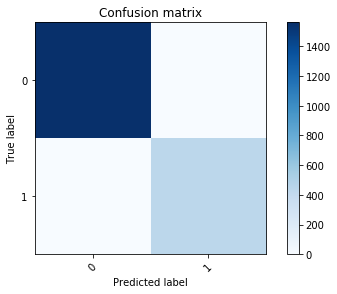

In [195]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_sig, outcome)
plt.show()

In [196]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      1.00      1.00       438

avg / total       1.00      1.00      1.00      2000



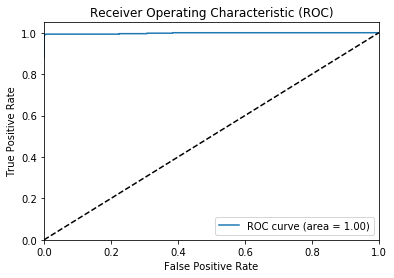

In [198]:
pred_sig = model_reg_sig.predict(x_nn_test)
pred_sig = pred_sig[:,1]
plot_roc(pred_sig,y_eval)

#### Tanh, adam 4 layers score_reg_tanh_stopping

In [101]:
# set up checkpointer
checkpointer_tanh = ModelCheckpoint(filepath="./best_weights_tanh_nn.hdf5", verbose=1, save_best_only=True)


In [102]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_nn_train.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(y.shape[1],activation='softmax')) # Output
    model_reg_tanh.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_tanh],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh_nn.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 0.0301 - val_loss: 0.0146

Epoch 00001: val_loss improved from inf to 0.01460, saving model to ./best_weights_tanh_nn.hdf5
Epoch 2/100
 - 2s - loss: 0.0029 - val_loss: 0.0118

Epoch 00002: val_loss improved from 0.01460 to 0.01182, saving model to ./best_weights_tanh_nn.hdf5
Epoch 3/100
 - 2s - loss: 0.0016 - val_loss: 0.0097

Epoch 00003: val_loss improved from 0.01182 to 0.00974, saving model to ./best_weights_tanh_nn.hdf5
Epoch 4/100
 - 2s - loss: 0.0021 - val_loss: 0.0158

Epoch 00004: val_loss did not improve from 0.00974
Epoch 5/100
 - 2s - loss: 0.0017 - val_loss: 0.0056

Epoch 00005: val_loss improved from 0.00974 to 0.00564, saving model to ./best_weights_tanh_nn.hdf5
Epoch 6/100
 - 1s - loss: 7.5510e-04 - val_loss: 5.4906e-04

Epoch 00006: val_loss improved from 0.00564 to 0.00055, saving model to ./best_weights_tanh_nn.hdf5
Epoch 7/100
 - 1s - loss: 1.6014e-04 - val_loss: 2.7870e-04

Epoch 00007: val

 - 9s - loss: 0.0146 - val_loss: 0.0153

Epoch 00001: val_loss did not improve from 0.00006
Epoch 2/100
 - 2s - loss: 0.0024 - val_loss: 0.0110

Epoch 00002: val_loss did not improve from 0.00006
Epoch 3/100
 - 2s - loss: 0.0016 - val_loss: 0.0111

Epoch 00003: val_loss did not improve from 0.00006
Epoch 4/100
 - 2s - loss: 2.6172e-04 - val_loss: 3.5123e-04

Epoch 00004: val_loss did not improve from 0.00006
Epoch 5/100
 - 2s - loss: 1.0191e-04 - val_loss: 1.3698e-04

Epoch 00005: val_loss did not improve from 0.00006
Epoch 6/100
 - 2s - loss: 6.7705e-05 - val_loss: 9.8619e-05

Epoch 00006: val_loss did not improve from 0.00006
Epoch 7/100
 - 2s - loss: 4.9690e-05 - val_loss: 7.7654e-05

Epoch 00007: val_loss did not improve from 0.00006
Epoch 00007: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 7s - loss: 0.0286 - val_loss: 0.0146

Epoch 00001: val_loss did not improve from 0.00006
Epoch 2/100
 - 2s - loss: 0.0030 - val_loss: 0.0130

Epoch 00002: val_

In [107]:
# Measure accuracy
pred_nn = model_reg_tanh.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [108]:
# Metrics

score_tf_acc_tanh = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_tanh))

score_tf_precision_tanh = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh))

score_tf_recall_tanh = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh))

score_tf_f1_tanh = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [199]:
cm_tanh = confusion_matrix(y_eval, pred_nn)
print(cm_tanh)

[[1562    0]
 [   0  438]]


In [200]:
outcome = encode_text_index(network_nn_df,'outcome')

In [201]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


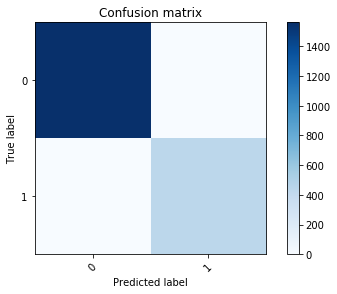

In [202]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_tanh, outcome)
plt.show()

In [203]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      1.00      1.00       438

avg / total       1.00      1.00      1.00      2000



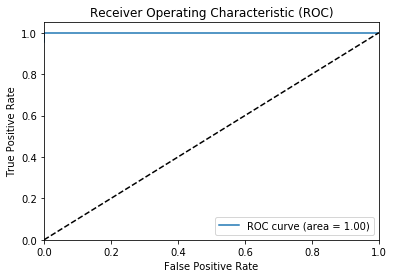

In [204]:
pred_tanh = model_reg_tanh.predict(x_nn_test)
pred_tanh = pred_tanh[:,1]
plot_roc(pred_tanh,y_eval)

## Convolutional Neural Network 

In [387]:
#Split for train and test

x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [388]:
x_cnn_train.shape

(8000, 124)

In [389]:
x_cnn_test.shape

(2000, 124)

In [390]:
y_cnn_train.shape

(8000, 2)

In [391]:
y_cnn_test.shape

(2000, 2)

In [392]:
# we now reshape the x_train and x_test to image form used in CNN 2D
x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 1, x_cnn_train.shape[1], 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 1, x_cnn_test.shape[1], 1)

In [394]:
x_cnn_train[0].shape

(1, 124, 1)

In [210]:
x_cnn_test.shape

(2000, 1, 124, 1)

In [109]:
checkpointer_cnn = ModelCheckpoint(filepath="./best_weights_cnn.hdf5", verbose=1, save_best_only=True)


In [111]:
# CNN 2D

for i in range(4):
    print(i)

    cnn = Sequential()

# Conv2D layer 1
    cnn.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=x_cnn_train[0].shape))
    cnn.add(Conv2D(64, (1, 3), activation='relu'))

    cnn.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn.add(Dropout(0.25))

    cnn.add(Flatten())

    cnn.add(Dense(128, activation='relu'))

    cnn.add(Dropout(0.5))

    cnn.add(Dense(2, activation='softmax'))

    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn.fit(x_cnn_train, y_cnn_train, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_cnn_test, y_cnn_test))

print('Training finished...Loading the best model') 
print()
cnn.load_weights('./best_weights_cnn.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
 - 146s - loss: 0.0668 - acc: 0.9741 - val_loss: 0.0191 - val_acc: 0.9975

Epoch 00001: val_loss improved from inf to 0.01914, saving model to ./best_weights_cnn.hdf5
Epoch 2/10
 - 134s - loss: 0.0029 - acc: 0.9990 - val_loss: 0.0103 - val_acc: 0.9985

Epoch 00002: val_loss improved from 0.01914 to 0.01032, saving model to ./best_weights_cnn.hdf5
Epoch 3/10
 - 133s - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0081 - val_acc: 0.9985

Epoch 00003: val_loss improved from 0.01032 to 0.00809, saving model to ./best_weights_cnn.hdf5
Epoch 4/10
 - 134s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0068 - val_acc: 0.9985

Epoch 00004: val_loss improved from 0.00809 to 0.00677, saving model to ./best_weights_cnn.hdf5
Epoch 5/10
 - 135s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0041 - val_acc: 0.9985

Epoch 00005: val_loss improved from 0.00677 to 0.00409, saving model to ./best_weights_cnn.hdf5
Epoch 6/10
 - 127s - loss: 0.0011 - acc: 0.9

In [112]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 1, 122, 41)        164       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 120, 64)        7936      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 60, 64)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 60, 64)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_359 (Dense)            (None, 128)               491648    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [211]:
# Evaluate Accuracy in Keras
score_cnn = cnn.evaluate(x_cnn_test, y_cnn_test, verbose=0)
score_cnn

[0.0009075921499897959, 1.0]

In [212]:
pred = cnn.predict(x_cnn_test)
pred = np.argmax(pred,axis=1)
pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [213]:
y_true = np.argmax(y_cnn_test,axis=1)
y_true

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [214]:
# Metrics

score_acc_cnn = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score_acc_cnn))

score_precision_cnn = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score_precision_cnn))

score_recall_cnn = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score_recall_cnn))

score_f1_cnn = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score_f1_cnn))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [215]:
cm_cnn = confusion_matrix(y_true, pred)
print(cm_cnn)

[[1562    0]
 [   0  438]]


In [216]:
outcome = encode_text_index(network_nn_df,'outcome')

Plotting confusion matrix


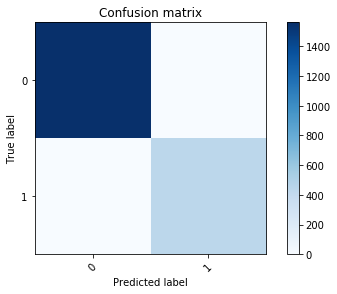

In [217]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn, outcome)
plt.show()

In [218]:
print(classification_report(y_true, pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1562
          1       1.00      1.00      1.00       438

avg / total       1.00      1.00      1.00      2000



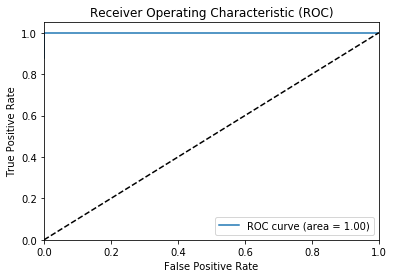

In [219]:
pred_cnn = cnn.predict(x_cnn_test)
pred_cnn = pred_cnn[:,1]
plot_roc(pred_cnn,y_true)

# Additional Features

## Removing Redundancy 

### Data Processing for classical models

In [3]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_af_df= pd.read_csv('network_intrusion_data.csv')

In [4]:
network_af_df.shape

(494020, 42)

In [5]:
#Drop any row with missing values
network_af_df = network_af_df.dropna()

In [6]:
network_af_df.shape

(494020, 42)

In [7]:
#Add column headers to the data in the dataframe
network_af_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [8]:
#Remove redundant rows
network_af_df.drop_duplicates(keep='first', inplace=True)

In [9]:
network_af_df.shape

(145585, 42)

In [10]:
network_af_df.shape

(145585, 42)

In [11]:
#Select colums for feature
features_af_df = network_af_df[['duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
                          
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
                          
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']]

In [12]:
#Label column
label_af_df = network_af_df[['outcome']]

In [21]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(features_af_df,"duration") 
normalize_numeric_minmax(features_af_df,"src_bytes") 
normalize_numeric_minmax(features_af_df,"dst_bytes") 
normalize_numeric_minmax(features_af_df,"wrong_fragment") 
normalize_numeric_minmax(features_af_df,"urgent") 

normalize_numeric_minmax(features_af_df,"hot") 
normalize_numeric_minmax(features_af_df,"num_failed_logins") 
normalize_numeric_minmax(features_af_df,"num_compromised") 
normalize_numeric_minmax(features_af_df,"num_root") 
normalize_numeric_minmax(features_af_df,"num_file_creations") 
normalize_numeric_minmax(features_af_df,"num_shells") 
normalize_numeric_minmax(features_af_df,"num_access_files") 
normalize_numeric_minmax(features_af_df,"num_outbound_cmds") 

normalize_numeric_minmax(features_af_df,"count") 
normalize_numeric_minmax(features_af_df,"srv_count") 
normalize_numeric_minmax(features_af_df,"serror_rate") 
normalize_numeric_minmax(features_af_df,"rerror_rate") 
normalize_numeric_minmax(features_af_df,"srv_rerror_rate")  
normalize_numeric_minmax(features_af_df,"same_srv_rate") 
normalize_numeric_minmax(features_af_df,"diff_srv_rate") 
normalize_numeric_minmax(features_af_df,"srv_diff_host_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_count") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_count") 
normalize_numeric_minmax(features_af_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_serror_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(features_af_df,"dst_host_srv_rerror_rate") 

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
#One hot coding discrete values (9)
encode_text_dummy(features_af_df,"protocol_type") 
encode_text_dummy(features_af_df,"service") 
encode_text_dummy(features_af_df,"flag") 
encode_text_dummy(features_af_df,"land") 

encode_text_dummy(features_af_df,"logged_in") 
encode_text_dummy(features_af_df,"root_shell") 
encode_text_dummy(features_af_df,"su_attempted") 
encode_text_dummy(features_af_df,"is_host_login") 
encode_text_dummy(features_af_df,"is_guest_login") 

In [23]:
#Binary encode the label column
label_af_df['outcome'] = label_af_df['outcome'].apply(encodeLabelBinary)

C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
features_af_df.shape

(145585, 124)

In [25]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
features_af_df = features_af_df[0:10000]
label_af_df = label_af_df[0:10000]

In [25]:
#Split for training and testing
x_af_train, x_af_test, y_af_train, y_af_test = train_test_split(features_af_df, label_af_df['outcome'] , test_size=0.2, random_state=42)

In [26]:
y_af_test.shape

(2000,)

###  Logistic Regression

In [268]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_af_train, y_af_train)

y_af_pred_logistic = Log_reg_model.predict(x_af_test)

In [269]:
# Metrics

score_acc_log_af = metrics.accuracy_score(y_af_test, y_af_pred_logistic)
print("Accuracy score: {}".format(score_acc_log_af))

score_precision_log_af = metrics.precision_score(y_af_test, y_af_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_precision_log_af))

score_recall_log_af = metrics.recall_score(y_af_test, y_af_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_recall_log_af))

score_f1_log_af = metrics.f1_score(y_af_test, y_af_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_f1_log_af))

Accuracy score: 0.999
Precision score: 0.9990010065425264
Recall score: 0.999
F1 score: 0.9989645374766222


In [270]:
cm_log_af = confusion_matrix(y_af_test, y_af_pred_logistic)
print(cm_log_af)

[[1985    0]
 [   2   13]]


In [271]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


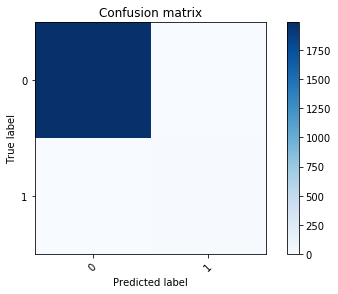

In [272]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_log_af, outcome)
plt.show()

In [273]:
print(classification_report(y_af_test, y_af_pred_logistic))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      0.87      0.93        15

avg / total       1.00      1.00      1.00      2000



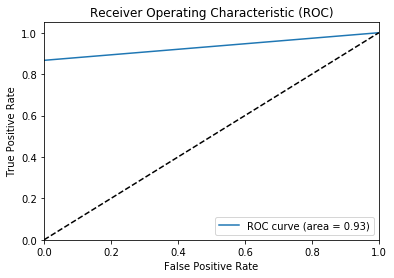

In [274]:
pred_log_af = Log_reg_model.predict(x_af_test)
pred_log_af = pred_log_af[:]
plot_roc(pred_log_af,y_af_test)

### KNN 

In [275]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_af_train, y_af_train) 

y_af_pred_knn = knn.predict(x_af_test)

In [276]:
# Metrics
from sklearn import metrics

score_af_knn_acc_af = metrics.accuracy_score(y_af_test, y_af_pred_knn)
print("Accuracy score: {}".format(score_af_knn_acc_af))

score_af_knn_precision_af = metrics.precision_score(y_af_test, y_af_pred_knn, average= "weighted")
print("Precision score: {}".format(score_af_knn_precision_af))

score_af_knn_recall_af = metrics.recall_score(y_af_test, y_af_pred_knn, average= "weighted")
print("Recall score: {}".format(score_af_knn_recall_af))

score_af_knn_f1_af = metrics.f1_score(y_af_test, y_af_pred_knn, average= "weighted")
print("F1 score: {}".format(score_af_knn_f1_af))

Accuracy score: 0.9995
Precision score: 0.9995002517623364
Recall score: 0.9995
F1 score: 0.999491442266779


In [277]:
cm_knn_af = confusion_matrix(y_af_test, y_af_pred_knn)
print(cm_knn_af)

[[1985    0]
 [   1   14]]


In [278]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


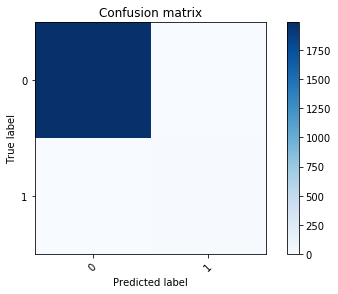

In [279]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_knn_af, outcome)
plt.show()

In [280]:
print(classification_report(y_af_test, y_af_pred_knn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      0.93      0.97        15

avg / total       1.00      1.00      1.00      2000



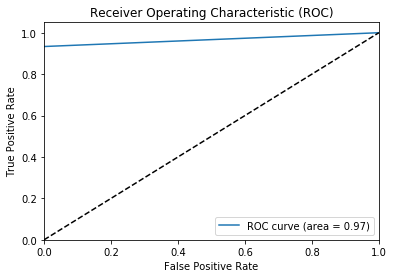

In [281]:
pred_knn_af = knn.predict(x_af_test)
pred_knn_af = pred_knn_af[:]
plot_roc(pred_knn_af,y_af_test)

### SVM 

In [284]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")

svm_model.fit(x_af_train, y_af_train)

y_af_pred_svm = svm_model.predict(x_af_test)

In [286]:
# Metrics

score_svm_acc_af = metrics.accuracy_score(y_af_test, y_af_pred_svm)
print("Accuracy score: {}".format(score_svm_acc_af))

score_svm_precision_af = metrics.precision_score(y_af_test, y_af_pred_svm, average= "weighted")
print("Precision score: {}".format(score_svm_precision_af))

score_svm_recall_af = metrics.recall_score(y_af_test, y_af_pred_svm, average= "weighted")
print("Recall score: {}".format(score_svm_recall_af))

score_svm_f1_af = metrics.f1_score(y_af_test, y_af_pred_svm, average= "weighted")
print("F1 score: {}".format(score_svm_f1_af))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [287]:
cm_svm_af = confusion_matrix(y_af_test, y_af_pred_svm)
print(cm_svm_af)

[[1985    0]
 [   0   15]]


In [288]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


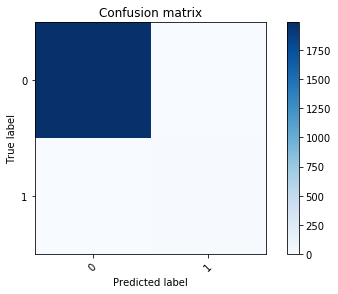

In [289]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_svm_af, outcome)
plt.show()

In [290]:
print(classification_report(y_af_test, y_af_pred_svm))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00      2000



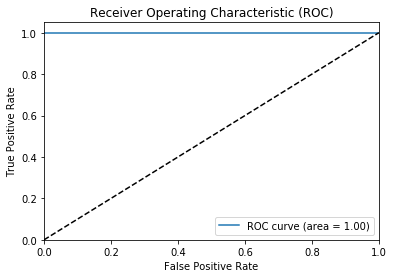

In [292]:
pred_svm_af = svm_model.predict(x_af_test)
pred_svm_af = pred_svm_af[:]
plot_roc(pred_svm_af,y_af_test)

### Gaussian Naive Bayes 

In [293]:
#GNB
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

gnb_model.fit(x_af_train, y_af_train)

y_af_pred_gnb = gnb_model.predict(x_af_test)

In [294]:
# Metrics

score_gnb_acc_af = metrics.accuracy_score(y_af_test, y_af_pred_gnb)
print("Accuracy score: {}".format(score_gnb_acc_af))

score_gnb_precision_af = metrics.precision_score(y_af_test, y_af_pred_gnb, average= "weighted")
print("Precision score: {}".format(score_gnb_precision_af))

score_gnb_recall_af = metrics.recall_score(y_af_test, y_af_pred_gnb, average= "weighted")
print("Recall score: {}".format(score_gnb_recall_af))

score_gnb_f1_af = metrics.f1_score(y_af_test, y_af_pred_gnb, average= "weighted")
print("F1 score: {}".format(score_gnb_f1_af))

Accuracy score: 0.997
Precision score: 0.9978571428571429
Recall score: 0.997
F1 score: 0.9972477295660948


In [295]:
cm_gnb_af = confusion_matrix(y_af_test, y_af_pred_gnb)
print(cm_gnb_af)

[[1979    6]
 [   0   15]]


In [296]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


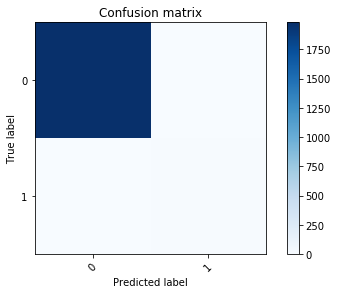

In [297]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_gnb_af, outcome)
plt.show()

In [298]:
print(classification_report(y_af_test, y_af_pred_gnb))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       0.71      1.00      0.83        15

avg / total       1.00      1.00      1.00      2000



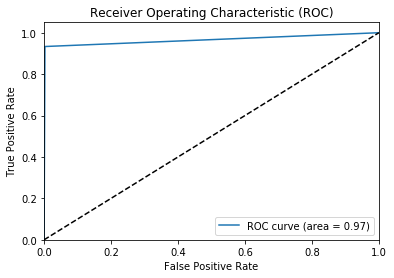

In [299]:
pred_gnb_af = mnb_model.predict(x_af_test)
pred_gnb_af = pred_gnb_af[:]
plot_roc(pred_gnb_af,y_af_test)

### Data processing for NN and CNN 

In [348]:
network_rr_df= pd.read_csv('network_intrusion_data.csv', delimiter =",")

In [349]:
#Add column headers to the data in the dataframe
network_rr_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [350]:
network_rr_df.shape

(494020, 42)

In [351]:
network_rr_df.drop_duplicates(keep='first', inplace=True)

In [352]:
network_rr_df.shape

(145585, 42)

In [353]:
network_rr_df.shape

(145585, 42)

In [354]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(network_rr_df,"duration") 
normalize_numeric_minmax(network_rr_df,"src_bytes") 
normalize_numeric_minmax(network_rr_df,"dst_bytes") 
normalize_numeric_minmax(network_rr_df,"wrong_fragment") 
normalize_numeric_minmax(network_rr_df,"urgent") 

normalize_numeric_minmax(network_rr_df,"hot") 
normalize_numeric_minmax(network_rr_df,"num_failed_logins") 
normalize_numeric_minmax(network_rr_df,"num_compromised") 
normalize_numeric_minmax(network_rr_df,"num_root") 
normalize_numeric_minmax(network_rr_df,"num_file_creations") 
normalize_numeric_minmax(network_rr_df,"num_shells") 
normalize_numeric_minmax(network_rr_df,"num_access_files") 
normalize_numeric_minmax(network_rr_df,"num_outbound_cmds") 

normalize_numeric_minmax(network_rr_df,"count") 
normalize_numeric_minmax(network_rr_df,"srv_count") 
normalize_numeric_minmax(network_rr_df,"serror_rate") 
normalize_numeric_minmax(network_rr_df,"rerror_rate") 
normalize_numeric_minmax(network_rr_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_rr_df,"same_srv_rate") 
normalize_numeric_minmax(network_rr_df,"diff_srv_rate") 
normalize_numeric_minmax(network_rr_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_count") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_rr_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_rr_df,"dst_host_srv_rerror_rate") 

In [355]:
#One hot coding discrete values (9)
encode_text_dummy(network_rr_df,"protocol_type") 
encode_text_dummy(network_rr_df,"service") 
encode_text_dummy(network_rr_df,"flag") 
encode_text_dummy(network_rr_df,"land") 
encode_text_dummy(network_rr_df,"logged_in") 
encode_text_dummy(network_rr_df,"root_shell") 
encode_text_dummy(network_rr_df,"su_attempted") 
encode_text_dummy(network_rr_df,"is_host_login") 
encode_text_dummy(network_rr_df,"is_guest_login") 

In [356]:
network_rr_df.shape

(145585, 125)

In [357]:
network_rr_df= network_rr_df[0:40000]

In [358]:
network_rr_df['outcome'] = network_rr_df['outcome'].apply(encodeLabelBinary)


In [359]:
network_rr_df.shape

(40000, 125)

In [360]:
x_af,y_af=to_xy(network_rr_df,"outcome")

In [361]:
x_af.shape

(40000, 124)

In [362]:
y_af.shape

(40000, 2)

### Fully connected Neural Network 

In [363]:
#Split for train and test
x_nn_train, x_nn_test, y_nn_train, y_nn_test = train_test_split(x_af,y_af, test_size=0.2, random_state=42)

#### ReLU, adam, 4 layers, early stopping and Model checkpoint  - score_4l

In [364]:
# set up checkpointer
checkpointer_relu_af = ModelCheckpoint(filepath="./best_weights_relu_4l_nn_af.hdf5", verbose=1, save_best_only=True)

In [366]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()
    model_reg_relu.add(Dense(10, input_dim=x_nn_train.shape[1], activation='relu'))
    model_reg_relu.add(Dense(50, activation='relu'))
    model_reg_relu.add(Dense(10, activation='relu'))
    model_reg_relu.add(Dense(1))
    model_reg_relu.add(Dense(y_af.shape[1],activation='softmax'))
    model_reg_relu.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_relu_af ],verbose=2,epochs=1000)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l_nn_af.hdf5')

0
Train on 32000 samples, validate on 8000 samples
Epoch 1/1000
 - 9s - loss: 0.1389 - val_loss: 0.0611

Epoch 00001: val_loss did not improve from 0.00361
Epoch 2/1000
 - 5s - loss: 0.0345 - val_loss: 0.0261

Epoch 00002: val_loss did not improve from 0.00361
Epoch 3/1000
 - 5s - loss: 0.0145 - val_loss: 0.0137

Epoch 00003: val_loss did not improve from 0.00361
Epoch 4/1000
 - 6s - loss: 0.0105 - val_loss: 0.0147

Epoch 00004: val_loss did not improve from 0.00361
Epoch 5/1000
 - 5s - loss: 0.0091 - val_loss: 0.0164

Epoch 00005: val_loss did not improve from 0.00361
Epoch 6/1000
 - 5s - loss: 0.0068 - val_loss: 0.0112

Epoch 00006: val_loss did not improve from 0.00361
Epoch 7/1000
 - 5s - loss: 0.0058 - val_loss: 0.0109

Epoch 00007: val_loss did not improve from 0.00361
Epoch 8/1000
 - 5s - loss: 0.0052 - val_loss: 0.0102

Epoch 00008: val_loss did not improve from 0.00361
Epoch 9/1000
 - 5s - loss: 0.0047 - val_loss: 0.0100

Epoch 00009: val_loss did not improve from 0.00361
Epoc


Epoch 00005: val_loss did not improve from 0.00248
Epoch 6/1000
 - 5s - loss: 0.0056 - val_loss: 0.0071

Epoch 00006: val_loss did not improve from 0.00248
Epoch 7/1000
 - 5s - loss: 0.0046 - val_loss: 0.0069

Epoch 00007: val_loss did not improve from 0.00248
Epoch 8/1000
 - 5s - loss: 0.0043 - val_loss: 0.0072

Epoch 00008: val_loss did not improve from 0.00248
Epoch 9/1000
 - 5s - loss: 0.0041 - val_loss: 0.0073

Epoch 00009: val_loss did not improve from 0.00248
Epoch 10/1000
 - 5s - loss: 0.0033 - val_loss: 0.0090

Epoch 00010: val_loss did not improve from 0.00248
Epoch 11/1000
 - 5s - loss: 0.0031 - val_loss: 0.0073

Epoch 00011: val_loss did not improve from 0.00248
Epoch 00011: early stopping
7
Train on 32000 samples, validate on 8000 samples
Epoch 1/1000
 - 9s - loss: 0.1163 - val_loss: 0.0397

Epoch 00001: val_loss did not improve from 0.00248
Epoch 2/1000
 - 5s - loss: 0.0234 - val_loss: 0.0112

Epoch 00002: val_loss did not improve from 0.00248
Epoch 3/1000
 - 5s - loss: 

In [367]:
# Measure accuracy
pred_nn = model_reg_relu.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [368]:
# Metrics

score_tf_acc_relu_af = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_relu_af))

score_tf_precision_relu_af = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_relu_af))

score_tf_recall_relu_af = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_relu_af))

score_tf_f1_relu_af = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_relu_af))

Accuracy score: 0.9995
Precision score: 0.999499261269548
Recall score: 0.9995
F1 score: 0.9994991991341993


In [369]:
cm_relu_af = confusion_matrix(y_eval, pred_nn)
print(cm_relu_af)

[[7698    1]
 [   3  298]]


In [370]:
outcome = encode_text_index(network_rr_df,'outcome')

In [371]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


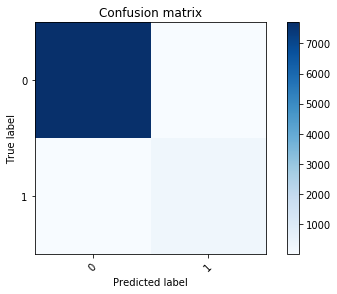

In [372]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_relu_af, outcome)
plt.show()

In [373]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7699
          1       1.00      0.99      0.99       301

avg / total       1.00      1.00      1.00      8000



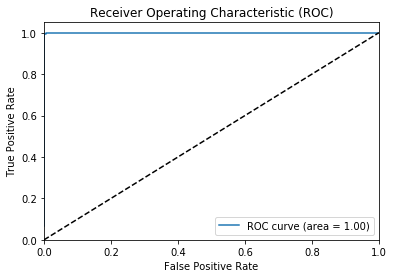

In [402]:
pred_relu_af = model_reg_relu.predict(x_nn_test)
pred_relu_af = pred_relu_af[:,1]
plot_roc(pred_relu_af,y_eval)

#### Sigmoid, adam, 4 layers  -score_reg_sig_stopping 

In [403]:
# set up checkpointer
checkpointer_sigmoid_af = ModelCheckpoint(filepath="./best_weights_sigmoid_nn_af.hdf5", verbose=1, save_best_only=True)

In [404]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_nn_train.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(y_af.shape[1],activation='softmax')) # Output
    model_reg_sig.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_sigmoid_af],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid_nn_af.hdf5')

0
Train on 32000 samples, validate on 8000 samples
Epoch 1/100
 - 11s - loss: 0.2008 - val_loss: 0.1603

Epoch 00001: val_loss improved from inf to 0.16030, saving model to ./best_weights_sigmoid_nn_af.hdf5
Epoch 2/100
 - 6s - loss: 0.1513 - val_loss: 0.1603

Epoch 00002: val_loss did not improve from 0.16030
Epoch 3/100
 - 7s - loss: 0.1513 - val_loss: 0.1603

Epoch 00003: val_loss did not improve from 0.16030
Epoch 4/100
 - 7s - loss: 0.1513 - val_loss: 0.1603

Epoch 00004: val_loss did not improve from 0.16030
Epoch 00004: early stopping
1
Train on 32000 samples, validate on 8000 samples
Epoch 1/100
 - 12s - loss: 0.1678 - val_loss: 0.1605

Epoch 00001: val_loss did not improve from 0.16030
Epoch 2/100
 - 6s - loss: 0.1514 - val_loss: 0.1606

Epoch 00002: val_loss did not improve from 0.16030
Epoch 3/100
 - 5s - loss: 0.1514 - val_loss: 0.1606

Epoch 00003: val_loss did not improve from 0.16030
Epoch 4/100
 - 5s - loss: 0.1514 - val_loss: 0.1604

Epoch 00004: val_loss did not improv

In [405]:
# Measure accuracy
pred_nn = model_reg_sig.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [406]:
# Metrics

score_tf_acc_sig_af = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_sig_af))

score_tf_precision_sig_af = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_sig_af))

score_tf_recall_sig_af = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_sig_af))

score_tf_f1_sig_af = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_sig_af))

Accuracy score: 0.962375
Precision score: 0.9261656406250001
Recall score: 0.962375
F1 score: 0.943923195744952


C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [407]:
cm_sig_af = confusion_matrix(y_eval, pred_nn)
print(cm_sig_af)

[[7699    0]
 [ 301    0]]


In [408]:
outcome = encode_text_index(network_rr_df,'outcome')

In [409]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


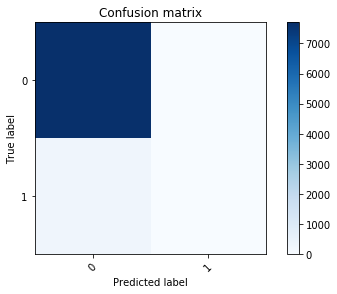

In [410]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_sig_af, outcome)
plt.show()

In [411]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98      7699
          1       0.00      0.00      0.00       301

avg / total       0.93      0.96      0.94      8000



C:\Users\ChandiniNagendra\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


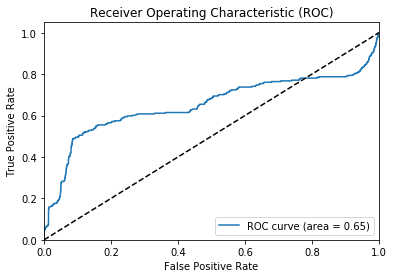

In [412]:
pred_sig_af = model_reg_sig.predict(x_nn_test)
pred_sig_af = pred_sig_af[:,1]
plot_roc(pred_sig_af,y_eval)

#### Tanh, adam 4 layers score_reg_tanh_stopping

In [413]:
# set up checkpointer
checkpointer_tanh_af = ModelCheckpoint(filepath="./best_weights_tanh_nn_af.hdf5", verbose=1, save_best_only=True)


In [414]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_nn_train.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(y_af.shape[1],activation='softmax')) # Output
    model_reg_tanh.compile(loss='categorical_crossentropy', optimizer='adagrad')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_nn_train,y_nn_train,validation_data=(x_nn_test,y_nn_test),callbacks=[monitor,checkpointer_tanh_af],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh_nn_af.hdf5')

0
Train on 32000 samples, validate on 8000 samples
Epoch 1/100
 - 11s - loss: 0.0525 - val_loss: 0.0165

Epoch 00001: val_loss improved from inf to 0.01647, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 2/100
 - 6s - loss: 0.0138 - val_loss: 0.0094

Epoch 00002: val_loss improved from 0.01647 to 0.00945, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 3/100
 - 6s - loss: 0.0109 - val_loss: 0.0085

Epoch 00003: val_loss improved from 0.00945 to 0.00851, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 4/100
 - 6s - loss: 0.0070 - val_loss: 0.0078

Epoch 00004: val_loss improved from 0.00851 to 0.00775, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 5/100
 - 6s - loss: 0.0062 - val_loss: 0.0077

Epoch 00005: val_loss improved from 0.00775 to 0.00768, saving model to ./best_weights_tanh_nn_af.hdf5
Epoch 6/100
 - 6s - loss: 0.0056 - val_loss: 0.0079

Epoch 00006: val_loss did not improve from 0.00768
Epoch 7/100
 - 6s - loss: 0.0054 - val_loss: 0.0076

Epoch 00007: va


Epoch 00003: val_loss did not improve from 0.00676
Epoch 4/100
 - 6s - loss: 0.0082 - val_loss: 0.0104

Epoch 00004: val_loss did not improve from 0.00676
Epoch 5/100
 - 6s - loss: 0.0071 - val_loss: 0.0084

Epoch 00005: val_loss did not improve from 0.00676
Epoch 6/100
 - 7s - loss: 0.0063 - val_loss: 0.0087

Epoch 00006: val_loss did not improve from 0.00676
Epoch 7/100
 - 8s - loss: 0.0060 - val_loss: 0.0081

Epoch 00007: val_loss did not improve from 0.00676
Epoch 8/100
 - 8s - loss: 0.0056 - val_loss: 0.0081

Epoch 00008: val_loss did not improve from 0.00676
Epoch 00008: early stopping
Training finished...Loading the best model



In [415]:
# Measure accuracy
pred_nn = model_reg_tanh.predict(x_nn_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_nn_test,axis=1)

In [416]:
# Metrics

score_tf_acc_tanh_af = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_tanh_af))

score_tf_precision_tanh_af = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh_af))

score_tf_recall_tanh_af = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh_af))

score_tf_f1_tanh_af = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh_af))

Accuracy score: 0.99775
Precision score: 0.9977914210868922
Recall score: 0.99775
F1 score: 0.9977641693030391


In [417]:
cm_tanh_af = confusion_matrix(y_eval, pred_nn)
print(cm_tanh_af)

[[7686   13]
 [   5  296]]


In [418]:
outcome = encode_text_index(network_rr_df,'outcome')

In [419]:
outcome

array([0, 1], dtype=int64)

Plotting confusion matrix


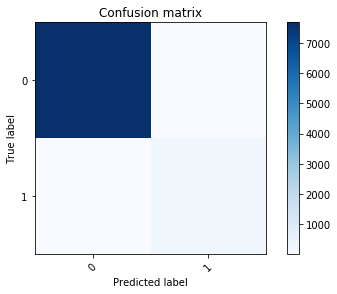

In [420]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_tanh_af, outcome)
plt.show()

In [421]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7699
          1       0.96      0.98      0.97       301

avg / total       1.00      1.00      1.00      8000



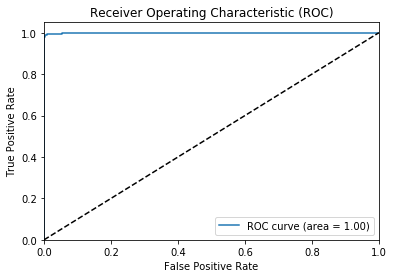

In [422]:
pred_tanh_af = model_reg_tanh.predict(x_nn_test)
pred_tanh_af = pred_tanh_af[:,1]
plot_roc(pred_tanh_af,y_eval)

### Convolutional Neural Network 

In [423]:
x_cnn_train_af, x_cnn_test_af, y_cnn_train_af, y_cnn_test_af = train_test_split(x_af,y_af, test_size=0.2, random_state=42)

In [424]:
x_cnn_train_af.shape

(32000, 124)

In [425]:
y_cnn_train_af.shape

(32000, 2)

In [426]:
# we now reshape the x_train and x_test to image form used in CNN 2D
x_cnn_train_af = x_cnn_train_af.reshape(x_cnn_train_af.shape[0], 1, x_cnn_train_af.shape[1], 1)
x_cnn_test_af = x_cnn_test_af.reshape(x_cnn_test_af.shape[0], 1, x_cnn_test_af.shape[1], 1)

In [427]:
x_cnn_train_af[0].shape

(1, 124, 1)

In [428]:
checkpointer_cnn_af = ModelCheckpoint(filepath="./best_weights_cnn_af.hdf5", verbose=1, save_best_only=True)


In [429]:
# CNN 2D

for i in range(4):
    print(i)

    cnn_af = Sequential()

# Conv2D layer 1
    cnn_af.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=x_cnn_train_af[0].shape))
    cnn_af.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_af.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_af.add(Dropout(0.25))

    cnn_af.add(Flatten())

    cnn_af.add(Dense(164, activation='relu'))

    cnn_af.add(Dropout(0.5))

    cnn_af.add(Dense(2, activation='softmax'))

    cnn_af.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn_af.fit(x_cnn_train_af, y_cnn_train_af, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn_af], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_cnn_test_af, y_cnn_test_af))

print('Training finished...Loading the best model') 
print()
cnn_af.load_weights('./best_weights_cnn_af.hdf5')

0
Train on 8000 samples, validate on 8000 samples
Epoch 1/10
 - 137s - loss: 0.0540 - acc: 0.9740 - val_loss: 0.3991 - val_acc: 0.9663

Epoch 00001: val_loss improved from inf to 0.39905, saving model to ./best_weights_cnn_af.hdf5
Epoch 2/10
 - 121s - loss: 0.0028 - acc: 0.9993 - val_loss: 0.3097 - val_acc: 0.9660

Epoch 00002: val_loss improved from 0.39905 to 0.30967, saving model to ./best_weights_cnn_af.hdf5
Epoch 3/10
 - 123s - loss: 0.0027 - acc: 0.9995 - val_loss: 0.3543 - val_acc: 0.9666

Epoch 00003: val_loss did not improve from 0.30967
Epoch 4/10
 - 122s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.2705 - val_acc: 0.9673

Epoch 00004: val_loss improved from 0.30967 to 0.27052, saving model to ./best_weights_cnn_af.hdf5
Epoch 5/10
 - 121s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.3404 - val_acc: 0.9669

Epoch 00005: val_loss did not improve from 0.27052
Epoch 6/10
 - 123s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.2940 - val_acc: 0.9674

Epoch 00006: val_loss did not improve f

In [430]:
cnn_af.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 1, 122, 41)        164       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 120, 82)        10168     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 60, 82)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 60, 82)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4920)              0         
_________________________________________________________________
dense_554 (Dense)            (None, 164)               807044    
_________________________________________________________________
dropout_20 (Dropout)         (None, 164)               0         
__________

In [431]:
# Evaluate Accuracy in Keras
score_cnn_af = cnn_af.evaluate(x_cnn_test, y_cnn_test, verbose=0)
score_cnn_af

[0.0019340453899349087, 1.0]

In [433]:
pred_cnn_af = cnn_af.predict(x_cnn_test_af)
pred_cnn_af = np.argmax(pred_cnn_af,axis=1)
pred_cnn_af

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [434]:
y_true_cnn_af = np.argmax(y_cnn_test_af,axis=1)
y_true_cnn_af

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [435]:
# Metrics

score_acc_cnn_af = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score_acc_cnn_af))

score_precision_cnn_af = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score_precision_cnn_af))

score_recall_cnn_af = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score_recall_cnn_af))

score_f1_cnn_af = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score_f1_cnn_af))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [436]:
cm_cnn_af = confusion_matrix(y_true_cnn_af, pred_cnn_af)
print(cm_cnn_af)

[[7684   15]
 [ 242   59]]


In [437]:
outcome = encode_text_index(network_rr_df,'outcome')

Plotting confusion matrix


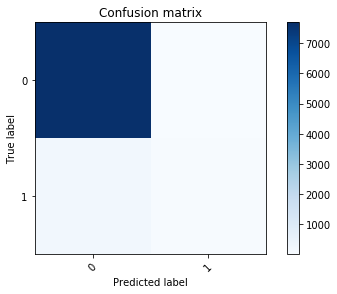

In [438]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn_af, outcome)
plt.show()

In [440]:
print(classification_report(y_true_cnn_af, pred_cnn_af))

             precision    recall  f1-score   support

          0       0.97      1.00      0.98      7699
          1       0.80      0.20      0.31       301

avg / total       0.96      0.97      0.96      8000



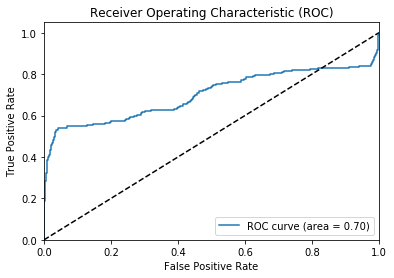

In [441]:
pred_cnn_af = cnn_af.predict(x_cnn_test_af)
pred_cnn_af = pred_cnn_af[:,1]
plot_roc(pred_cnn_af,y_true_cnn_af)

## Feature Importance Analysis 

### Feature importance and selection

In [29]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

extraTreeClassifier = ExtraTreesClassifier()
extraTreeClassifier.fit(features_af_df, label_af_df['outcome'])

# display the relative importance of each attribute

print(extraTreeClassifier.feature_importances_)

[9.05431656e-04 2.05090741e-02 1.50046873e-03 0.00000000e+00
 0.00000000e+00 3.29767537e-03 0.00000000e+00 1.96241226e-03
 5.00312129e-04 4.92555824e-03 3.87393609e-03 0.00000000e+00
 0.00000000e+00 6.56329284e-02 1.46502394e-01 1.02656536e-03
 2.81347149e-03 0.00000000e+00 0.00000000e+00 1.54320716e-03
 1.14518153e-03 2.42231275e-04 5.44357487e-02 2.01858021e-02
 9.45412087e-03 4.06085243e-04 1.02795721e-01 2.91674020e-03
 2.67904963e-03 4.69492866e-03 1.62023540e-06 1.30687594e-03
 1.15998511e-01 6.75301581e-03 4.94228765e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.15860412e-02 0.00000000e+00
 0.00000000e+00 2.18875996e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.01774748e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.30670281e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

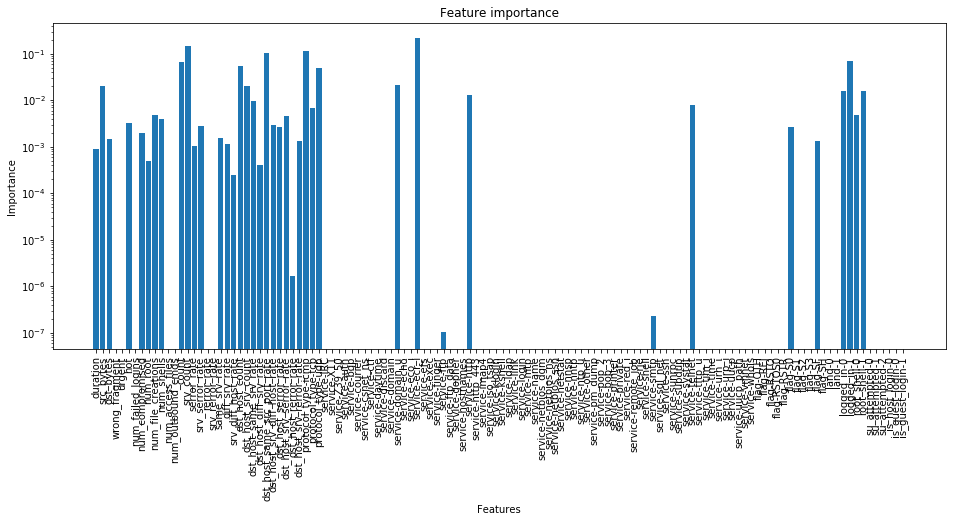

In [30]:
feature_importance = extraTreeClassifier.feature_importances_
plt.figure(figsize=(16, 6))
plt.yscale('log', nonposy='clip')
plt.bar(range(len(feature_importance)), feature_importance, align='center')
plt.xticks(range(len(feature_importance)), features_af_df, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [31]:
##Choose only relevant features

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(extraTreeClassifier, prefit=True)
X_new = model.transform(features_af_df)
feature_idx = model.get_support()
feature_name = features_af_df.columns[feature_idx]

In [32]:
feature_name

Index(['src_bytes', 'count', 'srv_count', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate', 'protocol_type-icmp',
       'protocol_type-udp', 'service-domain_u', 'service-ecr_i',
       'service-http', 'logged_in-0', 'logged_in-1', 'root_shell-1'],
      dtype='object')

In [447]:
#Train test split for feature analysis. Redundancy is removed from data here
x_adf_train, x_adf_test, y_adf_train, y_adf_test = train_test_split(X_new, label_af_df['outcome'] , test_size=0.2, random_state=42)

In [483]:
y_adf_test.shape

(2000,)

###  Logistic Regression  - score_adf_logistic

In [448]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

Log_reg_model = LogisticRegression()

Log_reg_model.fit(x_adf_train, y_adf_train)

y_adf_pred_logistic = Log_reg_model.predict(x_adf_test)

In [456]:
# Metrics

score_adf_logistic_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_logistic)
print("Accuracy score: {}".format(score_adf_logistic_acc))

score_adf_logistic_precision = metrics.precision_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("Precision score: {}".format(score_adf_logistic_precision))

score_adf_logistic_recall = metrics.recall_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("Recall score: {}".format(score_adf_logistic_recall))

score_adf_logistic_f1 = metrics.f1_score(y_adf_test, y_adf_pred_logistic, average= "weighted")
print("F1 score: {}".format(score_adf_logistic_f1))

Accuracy score: 0.999
Precision score: 0.9990010065425264
Recall score: 0.999
F1 score: 0.9989645374766222


In [451]:
cm_log_fa = confusion_matrix(y_adf_test, y_adf_pred_logistic)
print(cm_log_fa)

[[1985    0]
 [   2   13]]


In [452]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


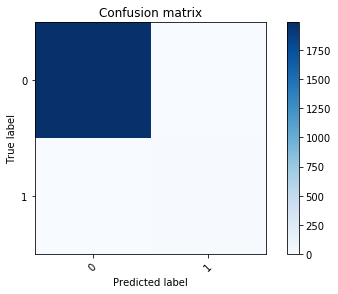

In [453]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_log_fa, outcome)
plt.show()

In [454]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      0.87      0.93        15

avg / total       1.00      1.00      1.00      2000



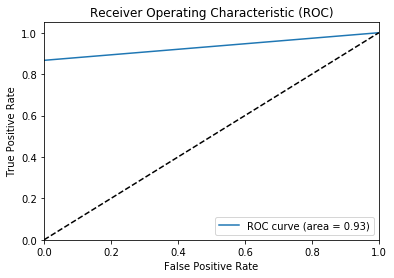

In [455]:
pred_log_fa = Log_reg_model.predict(x_adf_test)
pred_log_fa = pred_log_fa[:]
plot_roc(pred_log_fa,y_adf_test)

### KNN - score_adf_knn_acc

In [457]:
#implementing Nearest Neighbor

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_adf_train, y_adf_train) 

y_adf_pred_knn = knn.predict(x_adf_test)

In [459]:
# Metrics
from sklearn import metrics

score_adf_knn_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_knn)
print("Accuracy score: {}".format(score_adf_knn_acc))

score_adf_knn_precision = metrics.precision_score(y_adf_test, y_adf_pred_knn, average= "weighted")
print("Precision score: {}".format(score_adf_knn_precision))

score_adf_knn_recall = metrics.recall_score(y_adf_test, y_adf_pred_knn, average= "weighted")
print("Recall score: {}".format(score_adf_knn_recall))

score_adf_knn_f1 = metrics.f1_score(y_adf_test, y_adf_pred_knn, average= "weighted")
print("F1 score: {}".format(score_adf_knn_f1))

Accuracy score: 0.9995
Precision score: 0.9995002517623364
Recall score: 0.9995
F1 score: 0.999491442266779


In [461]:
cm_knn_fa = confusion_matrix(y_adf_test, y_adf_pred_knn)
print(cm_knn_fa)

[[1985    0]
 [   1   14]]


In [462]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


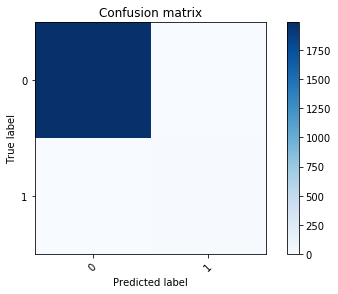

In [463]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_knn_fa, outcome)
plt.show()

In [464]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      0.87      0.93        15

avg / total       1.00      1.00      1.00      2000



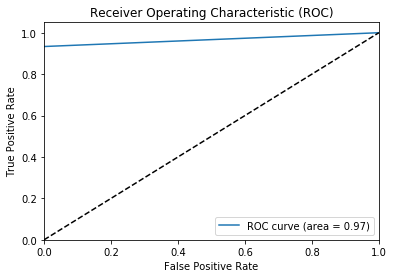

In [465]:
pred_knn_fa = knn.predict(x_adf_test)
pred_knn_fa = pred_knn_fa[:]
plot_roc(pred_knn_fa,y_adf_test)

###  SVM - score_adf_svm_acc

In [466]:
# SVM
from sklearn.svm import SVC

svm_model = SVC(kernel="linear")

svm_model.fit(x_adf_train, y_adf_train)

y_adf_pred_svm = svm_model.predict(x_adf_test)

In [468]:
# Metrics

score_adf_svm_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_svm)
print("Accuracy score: {}".format(score_adf_svm_acc))

score_adf_svm_precision = metrics.precision_score(y_adf_test, y_adf_pred_svm, average= "weighted")
print("Precision score: {}".format(score_adf_svm_precision))

score_adf_svm_recall = metrics.recall_score(y_adf_test, y_adf_pred_svm, average= "weighted")
print("Recall score: {}".format(score_adf_svm_recall))

score_adf_svm_f1 = metrics.f1_score(y_adf_test, y_adf_pred_svm, average= "weighted")
print("F1 score: {}".format(score_adf_svm_f1))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [469]:
cm_svm_fa = confusion_matrix(y_adf_test, y_adf_pred_svm)
print(cm_svm_fa)

[[1985    0]
 [   0   15]]


In [470]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


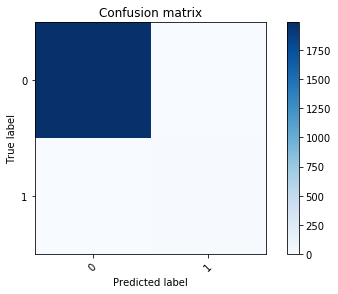

In [471]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_svm_fa, outcome)
plt.show()

In [472]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      0.87      0.93        15

avg / total       1.00      1.00      1.00      2000



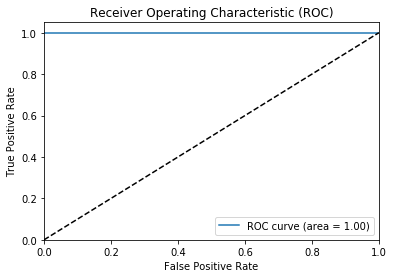

In [473]:
pred_svm_fa = svm_model.predict(x_adf_test)
pred_svm_fa = pred_svm_fa[:]
plot_roc(pred_svm_fa,y_adf_test)

### Gaussian Naive Bayes 

In [475]:
#GNB
from sklearn.naive_bayes import GaussianNB
gnb_model = GaussianNB()

gnb_model.fit(x_adf_train, y_adf_train)

y_adf_pred_gnb = gnb_model.predict(x_adf_test)

In [476]:
# Metrics

score_adf_gnb_acc = metrics.accuracy_score(y_adf_test, y_adf_pred_gnb)
print("Accuracy score: {}".format(score_adf_gnb_acc))

score_adf_gnb_precision = metrics.precision_score(y_adf_test, y_adf_pred_gnb, average= "weighted")
print("Precision score: {}".format(score_adf_gnb_precision))

score_adf_gnb_recall = metrics.recall_score(y_adf_test, y_adf_pred_gnb, average= "weighted")
print("Recall score: {}".format(score_adf_gnb_recall))

score_adf_gnb_f1 = metrics.f1_score(y_adf_test, y_adf_pred_gnb, average= "weighted")
print("F1 score: {}".format(score_adf_gnb_f1))

Accuracy score: 0.9875
Precision score: 0.9953125
Recall score: 0.9875
F1 score: 0.9903013019933172


In [477]:
cm_gnb_fa = confusion_matrix(y_adf_test, y_adf_pred_gnb)
print(cm_gnb_fa)

[[1960   25]
 [   0   15]]


In [478]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


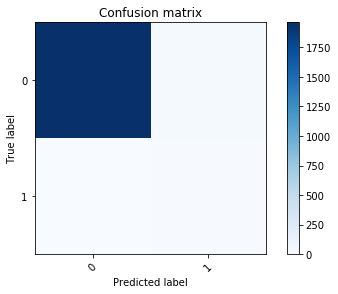

In [479]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_gnb_fa, outcome)
plt.show()

In [480]:
print(classification_report(y_adf_test, y_adf_pred_logistic))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      0.87      0.93        15

avg / total       1.00      1.00      1.00      2000



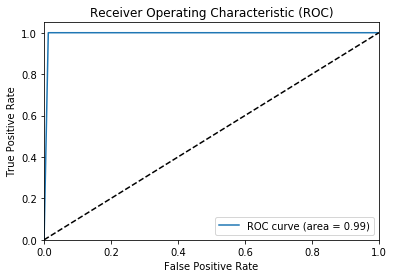

In [481]:
pred_gnb_fa = gnb_model.predict(x_adf_test)
pred_gnb_fa = pred_gnb_fa[:]
plot_roc(pred_gnb_fa,y_adf_test)

### Fully connected Neural Network

In [39]:
#Train test split for feature analysis. Redundancy is removed from data here
x_adf_train, x_adf_test, y_adf_train, y_adf_test = train_test_split(X_new, pd.get_dummies(label_af_df['outcome']).values.astype(np.float32), test_size=0.2, random_state=42)




In [40]:
x_adf_train.shape

(8000, 13)

#### ReLU, adam, 4 layers, early stopping and Model checkpoint  - score_4l

In [41]:
# set up checkpointer
checkpointer_relu_adf = ModelCheckpoint(filepath="./best_weights_relu_4l_nn_adf.hdf5", verbose=1, save_best_only=True)

In [42]:
# relu adam 4 layers
for i in range(10):
    print(i)
    
    # Build network
    model_reg_relu = Sequential()
    model_reg_relu.add(Dense(10, input_dim=x_adf_train.shape[1], activation='relu'))
    model_reg_relu.add(Dense(50, activation='relu'))
    model_reg_relu.add(Dense(10, activation='relu'))
    model_reg_relu.add(Dense(1))
    model_reg_relu.add(Dense(y_adf_train.shape[1],activation='softmax'))
    model_reg_relu.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    model_reg_relu.fit(x_adf_train,y_adf_train,validation_data=(x_adf_test,y_adf_test),callbacks=[monitor,checkpointer_relu_adf ],verbose=2,epochs=1000)
    
print('Training finished...Loading the best model') 
print()
model_reg_relu.load_weights('./best_weights_relu_4l_nn_adf.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
 - 1s - loss: 0.0808 - val_loss: 0.0088

Epoch 00001: val_loss improved from inf to 0.00884, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 2/1000
 - 0s - loss: 0.0055 - val_loss: 0.0059

Epoch 00002: val_loss improved from 0.00884 to 0.00589, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 3/1000
 - 0s - loss: 0.0035 - val_loss: 0.0040

Epoch 00003: val_loss improved from 0.00589 to 0.00395, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 4/1000
 - 0s - loss: 0.0023 - val_loss: 0.0030

Epoch 00004: val_loss improved from 0.00395 to 0.00296, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 5/1000
 - 0s - loss: 0.0015 - val_loss: 0.0023

Epoch 00005: val_loss improved from 0.00296 to 0.00227, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 6/1000
 - 0s - loss: 0.0011 - val_loss: 0.0020

Epoch 00006: val_loss improved from 0.00227 to 0.00202, saving model to ./best_weights_relu_4l_


Epoch 00013: val_loss improved from 0.00004 to 0.00004, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 14/1000
 - 0s - loss: 2.3815e-05 - val_loss: 3.0042e-05

Epoch 00014: val_loss improved from 0.00004 to 0.00003, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 15/1000
 - 0s - loss: 1.7774e-05 - val_loss: 2.1874e-05

Epoch 00015: val_loss improved from 0.00003 to 0.00002, saving model to ./best_weights_relu_4l_nn_adf.hdf5
Epoch 00015: early stopping
5
Train on 8000 samples, validate on 2000 samples
Epoch 1/1000
 - 1s - loss: 0.3432 - val_loss: 0.0156

Epoch 00001: val_loss did not improve from 0.00002
Epoch 2/1000
 - 0s - loss: 0.0082 - val_loss: 0.0088

Epoch 00002: val_loss did not improve from 0.00002
Epoch 3/1000
 - 0s - loss: 0.0053 - val_loss: 0.0070

Epoch 00003: val_loss did not improve from 0.00002
Epoch 4/1000
 - 0s - loss: 0.0041 - val_loss: 0.0065

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/1000
 - 0s - loss: 0.0034 - val_loss: 0.0054



In [43]:
# Measure accuracy
pred_nn = model_reg_relu.predict(x_adf_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_adf_test,axis=1)

In [44]:
# Metrics

score_tf_acc_relu_adf = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_relu_adf))

score_tf_precision_relu_adf = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_relu_adf))

score_tf_recall_relu_adf = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_relu_adf))

score_tf_f1_relu_adf = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_relu_adf))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [45]:
cm_relu_adf = confusion_matrix(y_eval, pred_nn)
print(cm_relu_adf)

[[1985    0]
 [   0   15]]


In [46]:
outcome = encode_text_index(label_af_df,'outcome')

In [47]:
outcome

array([0, 1])

Plotting confusion matrix


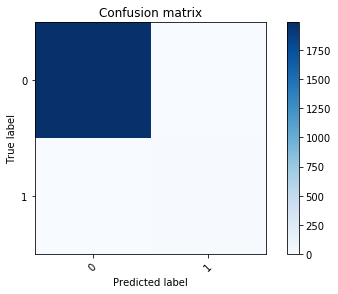

In [48]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_relu_adf, outcome)
plt.show()

In [49]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00      2000



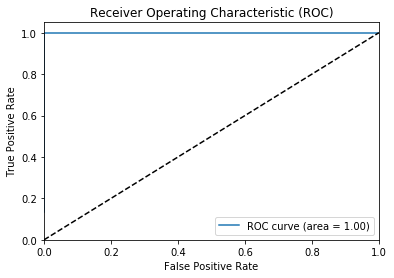

In [51]:
pred_relu_adf = model_reg_relu.predict(x_adf_test)
pred_relu_adf = pred_relu_adf[:,1]
plot_roc(pred_relu_adf,y_eval)

#### Sigmoid, adam, 4 layers  -score_reg_sig_stopping 

In [54]:
# set up checkpointer
checkpointer_sigmoid_adf = ModelCheckpoint(filepath="./best_weights_sigmoid_nn_adf.hdf5", verbose=1, save_best_only=True)

In [56]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_sig = Sequential()

    model_reg_sig.add(Dense(120, input_dim=x_adf_train.shape[1], activation='sigmoid'))  
    model_reg_sig.add(Dense(80, activation='sigmoid')) # Hidden 2
    model_reg_sig.add(Dense(60, activation='sigmoid')) # Hidden 3
    model_reg_sig.add(Dense(10, activation='sigmoid')) # Hidden 4
    model_reg_sig.add(Dense(y_adf_train.shape[1],activation='softmax')) # Output
    model_reg_sig.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_sig.fit(x_adf_train,y_adf_train,validation_data=(x_adf_test,y_adf_test),callbacks=[monitor,checkpointer_sigmoid_adf],verbose=2,epochs=100)
    
print('Training finished...Loading the best model') 
print()
model_reg_sig.load_weights('./best_weights_sigmoid_nn_adf.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.2446 - val_loss: 0.0731

Epoch 00001: val_loss improved from inf to 0.07309, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 2/100
 - 0s - loss: 0.0612 - val_loss: 0.0530

Epoch 00002: val_loss improved from 0.07309 to 0.05301, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 3/100
 - 0s - loss: 0.0511 - val_loss: 0.0481

Epoch 00003: val_loss improved from 0.05301 to 0.04809, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 4/100
 - 0s - loss: 0.0480 - val_loss: 0.0462

Epoch 00004: val_loss improved from 0.04809 to 0.04615, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 5/100
 - 0s - loss: 0.0468 - val_loss: 0.0453

Epoch 00005: val_loss improved from 0.04615 to 0.04529, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 6/100
 - 0s - loss: 0.0462 - val_loss: 0.0448

Epoch 00006: val_loss improved from 0.04529 to 0.04483, saving model to ./best_weights_sigmoid_nn_adf

 - 0s - loss: 0.0474 - val_loss: 0.0456

Epoch 00004: val_loss did not improve from 0.04429
Epoch 5/100
 - 0s - loss: 0.0464 - val_loss: 0.0450

Epoch 00005: val_loss did not improve from 0.04429
Epoch 6/100
 - 0s - loss: 0.0459 - val_loss: 0.0446

Epoch 00006: val_loss did not improve from 0.04429
Epoch 7/100
 - 0s - loss: 0.0457 - val_loss: 0.0445

Epoch 00007: val_loss did not improve from 0.04429
Epoch 8/100
 - 0s - loss: 0.0456 - val_loss: 0.0443

Epoch 00008: val_loss did not improve from 0.04429
Epoch 9/100
 - 0s - loss: 0.0455 - val_loss: 0.0443

Epoch 00009: val_loss improved from 0.04429 to 0.04427, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 10/100
 - 0s - loss: 0.0454 - val_loss: 0.0442

Epoch 00010: val_loss improved from 0.04427 to 0.04423, saving model to ./best_weights_sigmoid_nn_adf.hdf5
Epoch 00010: early stopping
9
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.0925 - val_loss: 0.0610

Epoch 00001: val_loss did not improve fr

In [57]:
# Measure accuracy
pred_nn = model_reg_sig.predict(x_adf_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_adf_test,axis=1)

In [58]:
# Metrics

score_tf_acc_sig_adf = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_sig_adf))

score_tf_precision_sig_adf = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_sig_adf))

score_tf_recall_sig_adf = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_sig_adf))

score_tf_f1_sig_adf = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_sig_adf))

Accuracy score: 0.9925
Precision score: 0.9850562500000001
Recall score: 0.9925
F1 score: 0.9887641154328731


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
cm_sig_adf = confusion_matrix(y_eval, pred_nn)
print(cm_sig_adf)

[[1985    0]
 [  15    0]]


In [60]:
outcome = encode_text_index(label_af_df,'outcome')

In [61]:
outcome

array([0, 1])

Plotting confusion matrix


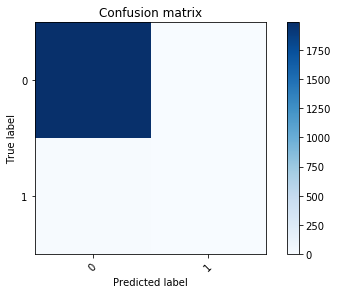

In [62]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_sig_adf, outcome)
plt.show()

In [63]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1985
          1       0.00      0.00      0.00        15

avg / total       0.99      0.99      0.99      2000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


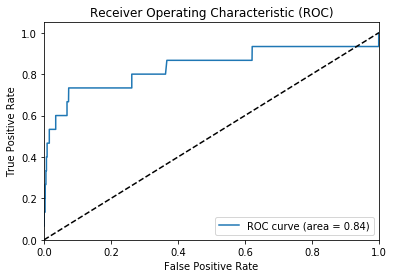

In [64]:
pred_sig_adf = model_reg_sig.predict(x_adf_test)
pred_sig_adf = pred_sig_adf[:,1]
plot_roc(pred_sig_adf,y_eval)

#### Tanh, adam 4 layers score_reg_tanh_stopping

In [65]:
# set up checkpointer
checkpointer_tanh_adf = ModelCheckpoint(filepath="./best_weights_tanh_nn_adf.hdf5", verbose=1, save_best_only=True)


In [66]:
for i in range(10):
    print(i)
    
    # Build network
    model_reg_tanh = Sequential()

    model_reg_tanh.add(Dense(120, input_dim=x_adf_train.shape[1], activation='tanh'))  
    model_reg_tanh.add(Dense(80, activation='tanh')) # Hidden 2
    model_reg_tanh.add(Dense(40, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(20, activation='tanh')) # Hidden 3
    model_reg_tanh.add(Dense(y_adf_train.shape[1],activation='softmax')) # Output
    model_reg_tanh.compile(loss='categorical_crossentropy', optimizer='adagrad')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    model_reg_tanh.fit(x_adf_train,y_adf_train,validation_data=(x_adf_test,y_adf_test),callbacks=[monitor,checkpointer_tanh_adf],verbose=2,epochs=100) 
    
print('Training finished...Loading the best model') 
print()
model_reg_tanh.load_weights('./best_weights_tanh_nn_adf.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.0110 - val_loss: 0.0025

Epoch 00001: val_loss improved from inf to 0.00248, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 2/100
 - 0s - loss: 0.0014 - val_loss: 8.6185e-04

Epoch 00002: val_loss improved from 0.00248 to 0.00086, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 3/100
 - 0s - loss: 6.0072e-04 - val_loss: 4.0494e-04

Epoch 00003: val_loss improved from 0.00086 to 0.00040, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 4/100
 - 0s - loss: 3.4707e-04 - val_loss: 2.6345e-04

Epoch 00004: val_loss improved from 0.00040 to 0.00026, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 5/100
 - 0s - loss: 2.5634e-04 - val_loss: 2.0709e-04

Epoch 00005: val_loss improved from 0.00026 to 0.00021, saving model to ./best_weights_tanh_nn_adf.hdf5
Epoch 00005: early stopping
1
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 0.0127 - val_loss: 0.0034

Epoch 0000

In [67]:
# Measure accuracy
pred_nn = model_reg_tanh.predict(x_adf_test)
pred_nn = np.argmax(pred_nn,axis=1)
y_eval = np.argmax(y_adf_test,axis=1)

In [68]:
# Metrics

score_tf_acc_tanh_adf = metrics.accuracy_score(y_eval, pred_nn)
print("Accuracy score: {}".format(score_tf_acc_tanh_adf))

score_tf_precision_tanh_adf = metrics.precision_score(y_eval, pred_nn, average= "weighted")
print("Precision score: {}".format(score_tf_precision_tanh_adf))

score_tf_recall_tanh_adf = metrics.recall_score(y_eval, pred_nn, average= "weighted")
print("Recall score: {}".format(score_tf_recall_tanh_adf))

score_tf_f1_tanh_adf = metrics.f1_score(y_eval, pred_nn, average= "weighted")
print("F1 score: {}".format(score_tf_f1_tanh_adf))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [69]:
cm_tanh_adf = confusion_matrix(y_eval, pred_nn)
print(cm_tanh_adf)

[[1985    0]
 [   0   15]]


In [70]:
outcome = encode_text_index(label_af_df,'outcome')

In [71]:
outcome

array([0, 1])

Plotting confusion matrix


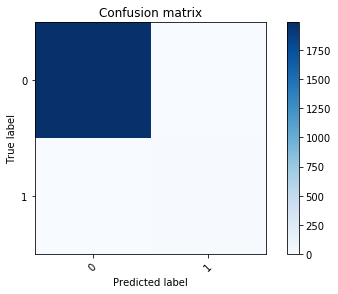

In [72]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_tanh_adf, outcome)
plt.show()

In [73]:
print(classification_report(y_eval, pred_nn))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00      2000



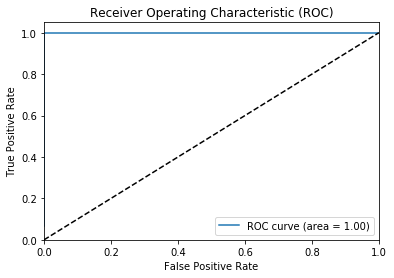

In [74]:
pred_tanh_adf = model_reg_tanh.predict(x_adf_test)
pred_tanh_adf = pred_tanh_adf[:,1]
plot_roc(pred_tanh_adf,y_eval)

### Convolutional Neural Network 

In [26]:
y_new = pd.get_dummies(label_af_df['outcome']).values.astype(np.float32)

In [27]:
y_new.shape

(10000, 2)

In [33]:
x_cnn_train_af, x_cnn_test_af, y_cnn_train_af, y_cnn_test_af = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

In [34]:
x_cnn_train_af.shape

(8000, 15)

In [35]:
y_cnn_train_af.shape

(8000, 2)

In [36]:
# we now reshape the x_train and x_test to image form used in CNN 2D
x_cnn_train_af = x_cnn_train_af.reshape(x_cnn_train_af.shape[0], 1, x_cnn_train_af.shape[1], 1)
x_cnn_test_af = x_cnn_test_af.reshape(x_cnn_test_af.shape[0], 1, x_cnn_test_af.shape[1], 1)

In [37]:
x_cnn_train_af[0].shape

(1, 15, 1)

In [92]:
checkpointer_cnn_adf = ModelCheckpoint(filepath="./best_weights_cnn_adf.hdf5", verbose=1, save_best_only=True)


In [94]:
# CNN 2D

for i in range(4):
    print(i)

    cnn_adf = Sequential()

# Conv2D layer 1
    cnn_adf.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=x_cnn_train_af[0].shape))
    cnn_adf.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_adf.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_adf.add(Dropout(0.25))
    
    cnn_adf.add(Flatten())

    cnn_adf.add(Dense(164, activation='relu'))

    cnn_adf.add(Dropout(0.5))

    cnn_adf.add(Dense(2, activation='softmax'))

    cnn_adf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn_adf.fit(x_cnn_train_af, y_cnn_train_af, 
            batch_size=128, 
            callbacks=[monitor,checkpointer_cnn_adf], 
            epochs=10, 
            verbose=2, 
            validation_data=(x_cnn_test_af, y_cnn_test_af))

print('Training finished...Loading the best model') 
print()
cnn_adf.load_weights('./best_weights_cnn_adf.hdf5')

0
Train on 8000 samples, validate on 2000 samples
Epoch 1/10
 - 2s - loss: 0.1028 - acc: 0.9826 - val_loss: 0.0182 - val_acc: 0.9925

Epoch 00001: val_loss did not improve from 0.00107
Epoch 2/10
 - 0s - loss: 0.0107 - acc: 0.9956 - val_loss: 0.0067 - val_acc: 0.9965

Epoch 00002: val_loss did not improve from 0.00107
Epoch 3/10
 - 0s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0045 - val_acc: 0.9990

Epoch 00003: val_loss did not improve from 0.00107
Epoch 4/10
 - 0s - loss: 0.0030 - acc: 0.9990 - val_loss: 0.0031 - val_acc: 0.9990

Epoch 00004: val_loss did not improve from 0.00107
Epoch 5/10
 - 0s - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0028 - val_acc: 0.9985

Epoch 00005: val_loss did not improve from 0.00107
Epoch 6/10
 - 0s - loss: 0.0023 - acc: 0.9993 - val_loss: 0.0018 - val_acc: 0.9990

Epoch 00006: val_loss did not improve from 0.00107
Epoch 7/10
 - 0s - loss: 0.0014 - acc: 0.9998 - val_loss: 0.0014 - val_acc: 0.9990

Epoch 00007: val_loss did not improve from 0.00107
Epoch

In [95]:
cnn_af.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 11, 41)         164       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 9, 82)          10168     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 4, 82)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 4, 82)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 328)               0         
_________________________________________________________________
dense_160 (Dense)            (None, 164)               53956     
_________________________________________________________________
dropout_2 (Dropout)          (None, 164)               0         
__________

In [96]:
# Evaluate Accuracy in Keras
score_cnn_adf = cnn_adf.evaluate(x_cnn_test_af, y_cnn_test_af, verbose=0)
score_cnn_adf

[0.0008088024972312269, 1.0]

In [97]:
pred_cnn_adf = cnn_adf.predict(x_cnn_test_af)
pred_cnn_adf = np.argmax(pred_cnn_adf,axis=1)
pred_cnn_adf

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
y_true_cnn_af = np.argmax(y_cnn_test_af,axis=1)
y_true_cnn_af

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
# Metrics

score_acc_cnn_adf = metrics.accuracy_score(y_true_cnn_af, pred_cnn_adf)
print("Accuracy score: {}".format(score_acc_cnn_adf))

score_precision_cnn_adf = metrics.precision_score(y_true_cnn_af, pred_cnn_adf, average= "weighted")
print("Precision score: {}".format(score_precision_cnn_adf))

score_recall_cnn_adf = metrics.recall_score(y_true_cnn_af, pred_cnn_adf, average= "weighted")
print("Recall score: {}".format(score_recall_cnn_adf))

score_f1_cnn_adf = metrics.f1_score(y_true_cnn_af, pred_cnn_adf, average= "weighted")
print("F1 score: {}".format(score_f1_cnn_adf))

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0


In [101]:
cm_cnn_adf = confusion_matrix(y_true_cnn_af, pred_cnn_adf)
print(cm_cnn_adf)

[[1985    0]
 [   0   15]]


In [102]:
outcome = encode_text_index(label_af_df,'outcome')

Plotting confusion matrix


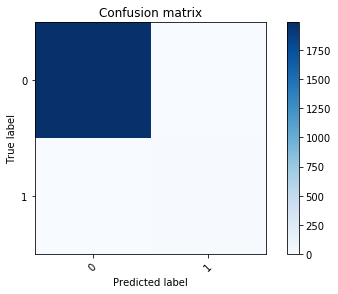

In [103]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn_adf, outcome)
plt.show()

In [104]:
print(classification_report(y_true_cnn_af, pred_cnn_adf))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1985
          1       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00      2000



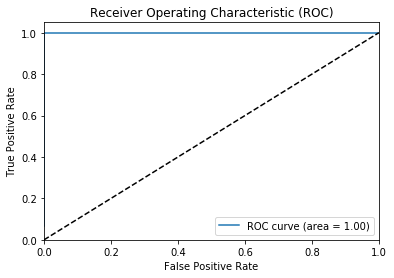

In [106]:
pred_cnn_adf = cnn_adf.predict(x_cnn_test_af)
pred_cnn_adf = pred_cnn_adf[:,1]
plot_roc(pred_cnn_adf,y_true_cnn_af)

## Experimenting with other proven CNN architecture 

### Data Processing for new CNN

In [55]:
#Read network_intrusion_data.csv file and load data into network_df dataframe 
network_cnn_af_df= pd.read_csv('network_intrusion_data.csv')

In [56]:
#Drop any row with missing values
network_cnn_af_df = network_cnn_af_df.dropna()

In [57]:
#Add column headers to the data in the dataframe
network_cnn_af_df.columns = [
'duration',
'protocol_type',
'service',
'flag',
'src_bytes',
'dst_bytes',
'land',
'wrong_fragment',
'urgent',
'hot',
'num_failed_logins',
'logged_in',
'num_compromised',
'root_shell',
'su_attempted',
'num_root',
'num_file_creations',
'num_shells',
'num_access_files',
'num_outbound_cmds',
'is_host_login',
'is_guest_login',
'count',
'srv_count',
'serror_rate',
'srv_serror_rate',
'rerror_rate',
'srv_rerror_rate',
'same_srv_rate',
'diff_srv_rate',
'srv_diff_host_rate',
'dst_host_count',
'dst_host_srv_count',
'dst_host_same_srv_rate',
'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate',
'dst_host_serror_rate',
'dst_host_srv_serror_rate',
'dst_host_rerror_rate',
'dst_host_srv_rerror_rate',
'outcome'
]

In [58]:
network_cnn_af_df.drop_duplicates(keep='first', inplace=True)

In [59]:
#Normalize all feature columns with continuese valuese (31)

normalize_numeric_minmax(network_cnn_af_df,"duration") 
normalize_numeric_minmax(network_cnn_af_df,"src_bytes") 
normalize_numeric_minmax(network_cnn_af_df,"dst_bytes") 
normalize_numeric_minmax(network_cnn_af_df,"wrong_fragment") 
normalize_numeric_minmax(network_cnn_af_df,"urgent") 

normalize_numeric_minmax(network_cnn_af_df,"hot") 
normalize_numeric_minmax(network_cnn_af_df,"num_failed_logins") 
normalize_numeric_minmax(network_cnn_af_df,"num_compromised") 
normalize_numeric_minmax(network_cnn_af_df,"num_root") 
normalize_numeric_minmax(network_cnn_af_df,"num_file_creations") 
normalize_numeric_minmax(network_cnn_af_df,"num_shells") 
normalize_numeric_minmax(network_cnn_af_df,"num_access_files") 
normalize_numeric_minmax(network_cnn_af_df,"num_outbound_cmds") 

normalize_numeric_minmax(network_cnn_af_df,"count") 
normalize_numeric_minmax(network_cnn_af_df,"srv_count") 
normalize_numeric_minmax(network_cnn_af_df,"serror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"rerror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"srv_rerror_rate")  
normalize_numeric_minmax(network_cnn_af_df,"same_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"diff_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"srv_diff_host_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_count") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_count") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_same_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_diff_srv_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_same_src_port_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_diff_host_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_serror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_serror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_rerror_rate") 
normalize_numeric_minmax(network_cnn_af_df,"dst_host_srv_rerror_rate") 

In [60]:
#One hot coding discrete values (9)
encode_text_dummy(network_cnn_af_df,"protocol_type") 
encode_text_dummy(network_cnn_af_df,"service") 
encode_text_dummy(network_cnn_af_df,"flag") 
encode_text_dummy(network_cnn_af_df,"land") 
encode_text_dummy(network_cnn_af_df,"logged_in") 
encode_text_dummy(network_cnn_af_df,"root_shell") 
encode_text_dummy(network_cnn_af_df,"su_attempted") 
encode_text_dummy(network_cnn_af_df,"is_host_login") 
encode_text_dummy(network_cnn_af_df,"is_guest_login") 

In [61]:
#Reduce the data set as the original is too large for classics to run for testing. Remove this section later
network_cnn_af_df = network_cnn_af_df[0:40000]

In [62]:
#Binary encode the label column
network_cnn_af_df['outcome'] = network_cnn_af_df['outcome'].apply(encodeLabelBinary)

In [63]:
# to xy to convert pandas to tensor flow
x_af,y_af=to_xy(network_cnn_af_df,"outcome")

In [65]:
x_af.shape

(40000, 124)

In [66]:
y_af.shape

(40000, 2)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x_af,y_af, test_size=0.2, random_state=42)

In [70]:
x_train = x_train.reshape(x_train.shape[0], 1,x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], 1,x_test.shape[1], 1)

### CNN Model

In [75]:
checkpointer_cnn_exp = ModelCheckpoint(filepath="./best_weights_cnn_exp.hdf5", verbose=1, save_best_only=True)

In [ ]:
# CNN 2D

for i in range(4):
    print(i)
    
    cnn_exp = Sequential()

    cnn_exp.add(Conv2D(41, kernel_size=(1, 3), strides=(1, 1),
                       padding='valid',
                       activation='relu',
                       input_shape=x_train[1].shape))
    
    cnn_exp.add(Conv2D(41, (1, 3), activation='relu'))

    cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_exp.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(82, (1, 3), activation='relu'))

    cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_exp.add(Conv2D(164, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(164, (1, 3), activation='relu'))

    cnn_exp.add(Conv2D(164, (1, 3), activation='relu'))

    cnn_exp.add(MaxPooling2D(pool_size=(1, 2), strides=None))

    cnn_exp.add(Flatten())
    
    cnn_exp.add(Dense(100, activation='relu'))

    cnn_exp.add(Dropout(0.5))

    cnn_exp.add(Dense(20, activation='relu'))

    cnn_exp.add(Dense(2, activation='softmax'))
    
    cnn_exp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
    
    cnn_exp.fit(x_train, y_train,
                batch_size=128,
                callbacks=[monitor,checkpointer_cnn_exp],
                epochs=10,
                verbose=2,
                validation_data=(x_test, y_test))
    
print('Training finished...Loading the best model') 
print()
cnn_exp.load_weights('./best_weights_cnn_exp.hdf5')


0
Train on 32000 samples, validate on 8000 samples
Epoch 1/10


In [ ]:
# Evaluate Accuracy in Keras
score = cnn_exp.evaluate(x_test, y_test, verbose=0)
score

In [ ]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

In [ ]:
pred_cnn_exp = cnn_exp.predict(x_test)
pred_cnn_exp = np.argmax(pred_cnn_exp,axis=1)

In [ ]:
pred_cnn_exp

In [ ]:
y_true_cnn_exp = np.argmax(y_test,axis=1)
y_true_cnn_exp

In [ ]:
# Metrics

score_acc_cnn_exp = metrics.accuracy_score(y_true_cnn_exp, pred_cnn_exp)
print("Accuracy score: {}".format(score_acc_cnn_exp))

score_precision_cnn_exp = metrics.precision_score(y_true_cnn_exp, pred_cnn_exp, average= "weighted")
print("Precision score: {}".format(score_precision_cnn_exp))

score_recall_cnn_exp = metrics.recall_score(y_true_cnn_exp, pred_cnn_exp, average= "weighted")
print("Recall score: {}".format(score_recall_cnn_exp))

score_f1_cnn_exp = metrics.f1_score(y_true_cnn_exp, pred_cnn_exp, average= "weighted")
print("F1 score: {}".format(score_f1_cnn_exp))

In [ ]:
cm_cnn_exp = confusion_matrix(y_true_cnn_exp, pred_cnn_exp)
print(cm_cnn_exp)

In [ ]:
outcome = encode_text_index(network_cnn_af_df,'outcome')

In [ ]:
outcome

In [ ]:
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm_cnn_exp, outcome)
plt.show()

In [ ]:
print(classification_report(y_true_cnn_exp, pred_cnn_exp))

In [ ]:
pred_cnn_exp = cnn_exp.predict(x_test)
pred_cnn_exp = pred[:,1]
plot_roc(pred_cnn_exp,y_true_cnn_exp)

## Multilabel Classification 